# Analysis code for _Intensional Gaps_
# TODO: modify this cell for details about new finite+nonfinite analysis

[Aaron Steven White](http://aaronstevenwhite.io)<br/>
*University of Rochester*<br/>
aaron.white@rochester.edu<br/>
*Last updated*: 8 May 2021

This notebook contains all of the analyses from:

> Kane, Benjamin, William Gantt, and Aaron Steven White. 2021. [Intensional gaps: Relating doxasticity, bouleticity, veridicality, factivity, and neg-raising](https://ling.auf.net/lingbuzz/005930/current.pdf). Accepted to _Semantics and Linguistic Theory_ 31.

If you use any of the code found in this directory, please cite that paper as well as [this repository](https://github.com/MegaAttitude/intensional-gaps.git).

## Notebook Contents

Code relevant to each of the following sections can be jumped to using the links below.

- [Section 3 (Validating a templatic approach)](#Validating-a-templatic-approach)
- [Section 4 (Lexicon-scale data collection)](#Lexicon-scale-data-collection)
- [Section 5 (Discovering inference patterns)](#Discovering-inference-patterns)

These links will not work when viewing this notebook on github.

## Environment Setup

It is strongly recommended that you run this notebook using the docker image it is shipped with. See the README shipped with this notebook for details. The relevant Dockerfile is duplicated below.

```
FROM jupyter/datascience-notebook:r-4.2.3

RUN pip install pyro-ppl==1.8.4 &&\
    R -e "install.packages(c('tidyverse', 'lme4', 'glmmTMB', 'ggrepel'), repos = 'https://cloud.r-project.org')"
```

To run the jupyter notebook server, use:

```bash
docker run -it --rm --user $(id -u):$(id -g) --group-add users -v "$(pwd)":/home/jovyan -p 8888:8888 --name intensional-gaps intensional-gaps
```

Failure to use this docker image could result in minor differences in statistics from the published paper or inability to run the code at all due to API changes.

In [1772]:
# base libraries
import os
import re
import json
import pickle

from typing import List, Optional
from warnings import warn
from dataclasses import dataclass
from collections import defaultdict

# numerical computing libraries
import numpy as np
import scipy.stats
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from torch.utils.data import DataLoader

from numpy.linalg import inv
from numpy import logaddexp
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import spearmanr

# mixture model
import pyro
import pyro.distributions as pdist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide.initialization import init_to_uniform
from pyro.infer import MCMC, NUTS

# regression, cross-validation, and PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# plotting libraries
import seaborn as sns
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [1773]:
USE_CHECKPOINTS = True
CHECKPOINT_DIR = 'ckpt-sem-syn'
if USE_CHECKPOINTS and not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

All the data needed for the analyses in this notebook are downloaded at run time, so an internet connection is also required.

In [1774]:
!mkdir -p data
!mkdir -p plots

In cases where values on $[0, 1]$ must be clipped to $(0, 1)$—e.g. for models that use the Beta distribution—we use the following values.

In [1775]:
ZERO = 1e-5
ONE = 1 - ZERO
INF = 1e38

In [1776]:
project_href = "http://megaattitude.io/projects/mega-intensionality/"

## Lexicon-scale data collection

We collect the MegaIntensionality dataset using the templatic methodology validated above.

In [1777]:
bulk1_href = project_href  + 'mega-intensionality-v1/mega-intensionality-v1.tsv'
bulk2_href = 'data/mega-intensionality-nonfinite.tsv'

mc1 = pd.read_csv(bulk1_href, sep='\t')
mc1['participant'] = mc1['participant'].astype('str') + '_1'
mc2 = pd.read_csv(bulk2_href, sep='\t')
mc2['participant'] = mc2['participant'].astype('str') + '_2'

mc = pd.concat([mc1, mc2])
mc_cols = list(mc.columns)
mc_cols_reordered = mc_cols[0:mc_cols.index('target')] + ['target', 'control'] + mc_cols[mc_cols.index('target')+1:-1]
mc = mc[mc_cols_reordered]
mc['participant'] = mc['participant'].astype('category').cat.codes
mc['control'] = mc['control'].fillna('na')

mc

,participant,antecedent_verb,antecedent_polarity,target,control,antecedent_frame,consequent_verb,consequent_embedded_tense,antecedent_text,consequent_text,response,sanity
0,506,fess_up,negative,object,na,NP V to NP that S[+future],want,future,A didn't fess up to B that C would happen,B wanted C to happen,0.38,4
1,506,consider,positive,subject,na,NP V that S,want,past,A considered that C happened,A wanted C to have happened,0.78,4
2,506,traumatize,negative,subject,na,NP be V that S[+future],believe,future,A wasn't traumatized that C would happen,A believed that C would happen,0.67,4
3,506,speculate,positive,object,na,NP V to NP that S[+future],believe,future,A speculated to B that C would happen,B believed that C would happen,0.63,4
4,506,blare,positive,subject,na,NP V that S[-tense],want,future,A blared that C happen,A wanted C to happen,0.86,4
...,...,...,...,...,...,...,...,...,...,...,...,...
92635,335,cause,negative,subject,object,NP V NP to VP[+eventive],believe,future,A didn't cause B to do C.,How likely is it that A believed that B would ...,0.29,4
92636,335,perceive,positive,object,object,NP V NP to VP[+eventive],intend,future,A perceived B to do C.,How likely is it that B intended to do C?,0.50,4
92637,335,steer,negative,object,object,NP V NP to VP[+eventive],intend,future,A didn't steer B to do C.,How likely is it that B intended to do C?,0.50,4
92638,335,sign_on,positive,subject,subject,NP V to VP[+eventive],intend,future,A signed on to do C.,How likely is it that A intended to do C?,1.00,4


To visualize these data, we first derive an aggregate score using a beta mixed model-based normalizer.

In [1778]:
def hash_column(col: pd.Series) -> np.array:
    col_as_cat = col.astype('category')
    
    values = torch.tensor(col_as_cat.cat.codes.values).type(torch.long)
    categories = col_as_cat.cat.categories
    
    return values, categories

class UnitNormalizer:
    
    required_columns = ['item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, seed: int = 42):
        self._seed = seed
    
    def _validate_data(self, data: pd.DataFrame) -> None:
        for col in self.required_columns:
            if col not in data.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')
                
    def _prepare_data(self, data: pd.DataFrame) -> None:
        self._raw_data = data
        
        self._validate_data(data)

        for col in self.required_columns:
            if col == 'response':
                setattr(self, col, torch.tensor(data[col].values).type(torch.float))
                setattr(self, f'n_{col}', data.shape[0])

            else:
                values, categories = hash_column(data[col])
                setattr(self, col, values)
                setattr(self, f'{col}_categories', categories)
                setattr(self, f'n_{col}', len(categories))
    
    def _init_loc_fn(self, site):        
        return init_to_uniform(site, radius=1e-3)
    
    def _initialize_model(self):
        
        def model(item, participant, response):
            scale = pyro.sample('scale', pdist.Normal(0., self.large_variance))
            
            # Vector of variances for each of the d variables
            theta = pyro.sample("theta", pdist.HalfCauchy(torch.ones(2)).to_event(1))
            # Lower cholesky factor of a correlation matrix
            L_omega = pyro.sample("L_omega", pdist.LKJCorrCholesky(2, 1.0))
            # Lower cholesky factor of the covariance matrix
            participant_scale = torch.mm(theta.sqrt().diag_embed(), L_omega)
            
            with pyro.plate('item_plate', self.n_item):
                locs = pyro.sample('locs', pdist.Normal(0, self.large_variance))
            
            with pyro.plate('participant_plate', self.n_participant):
                locs_scales_participant = pyro.sample('locs_scales_participant',
                                                      pdist.MultivariateNormal(torch.zeros(2),
                                                                              scale_tril=participant_scale))

            with pyro.plate('response_plate', self.n_response):                
                locs = torch.sigmoid(locs[item] + locs_scales_participant[participant, 1])
                scales = torch.square(scale + locs_scales_participant[participant, 0])
                
                concentration1 = scales*locs
                concentration0 = scales*(1.-locs)

                pyro.sample('obs', 
                            pdist.Beta(concentration1.clamp(min=ZERO),
                                      concentration0.clamp(min=ZERO)), 
                            obs=response)
                
                lp = pdist.Beta(concentration1.clamp(min=ZERO), 
                               concentration0.clamp(min=ZERO)).log_prob(response)
                
                return lp
            
        guide = AutoDelta(model, init_loc_fn=self._init_loc_fn)
        
        return model, guide

    def fit(self, data: pd.DataFrame, lr: float = 0.05, tolerance=0.0005, window_size=100,
            iterations: int=1000, verbosity: int=10) -> 'UnitNormalizer':
        pyro.set_rng_seed(self._seed)
        pyro.clear_param_store()
        
        self._prepare_data(data)
        
        optim = pyro.optim.Adam({'lr': lr})
        self._elbo = Trace_ELBO(max_plate_nesting=1)
        
        self._model, self._guide = self._initialize_model()
        
        svi = SVI(self._model, self._guide, optim, loss=self._elbo)
        
        losses = []
         
        like_hist = []
        prev_like_sum = -np.inf
            
        for i in range(iterations):
            
            loss = svi.step(self.item, self.participant, self.response)
            losses.append(loss)
            
            if i and not i % verbosity:
                print('ELBO:', np.round(loss, 2))
        
        return self
    
    def param(self, param_name):
        return pyro.get_param_store()[f'AutoDelta.{param_name}']

In [1779]:
mc['item'] = mc.antecedent_verb + '-' + mc.antecedent_polarity + '-' + mc.antecedent_frame + '-' +\
             mc.target + '-' + mc.control + '-' + mc.consequent_verb + '-' + mc.consequent_embedded_tense

mc['response'] = mc.response.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

if not os.path.isfile('data/mega-intensionality-v2-normalized.tsv'):

    normalizer_checkpoint = f'{CHECKPOINT_DIR}/unit_normalizer.pickle'
    if USE_CHECKPOINTS and os.path.isfile(normalizer_checkpoint):
        print(f'Loading unit normalizer from checkpoint...')
        with open(normalizer_checkpoint, 'rb') as f:
            normalizer = pickle.load(f)

    else:
        normalizer = UnitNormalizer().fit(mc, iterations=50000, lr=0.1, verbosity=5000)

        if USE_CHECKPOINTS:
            with open(normalizer_checkpoint, 'wb') as f:
                pickle.dump(normalizer, f)

The resulting normalized values are made available [here](http://megaattitude.io/projects/mega-intensionality/mega-intensionality-v1/mega-intensionality-v1-normalized.tsv).

In [1780]:
if not os.path.isfile('data/mega-intensionality-v2-normalized.tsv'):
    
    keep_cols = ['item', 'antecedent_verb', 'antecedent_polarity', 'antecedent_frame', 
                 'target', 'control', 'consequent_verb', 'consequent_embedded_tense', 'antecedent_text']

    mc_normalized = pd.merge(mc[keep_cols].drop_duplicates().reset_index(drop=True),
                             pd.DataFrame(list(zip(normalizer.item_categories.values, 
                                                   torch.sigmoid(normalizer.param('locs')).data.numpy())), 
                                          columns=['item', 'response_normalized']))

    mc_normalized = mc_normalized.drop(columns='item')

    mc_normalized.sort_values('response_normalized')

    mc_normalized.to_csv('data/mega-intensionality-v2-normalized.tsv', sep='\t', index=False)
    
else:
    mc_normalized = pd.read_csv('data/mega-intensionality-v2-normalized.tsv', sep='\t')

Figure 3 in the paper plots these normalized values.

For passive frames, we set the target (and control, if any) to "object".

In [1781]:
passive_frames = ['NP be V that S[+future]',
                  'NP be V that S[-tense]',
                  'NP be V to VP[-eventive]',
                  'NP be V to VP[+eventive]']
mc_normalized.loc[mc_normalized['antecedent_frame'].isin(passive_frames), 'target'] = 'object'
mc_normalized.loc[(mc_normalized['antecedent_frame'].isin(passive_frames) & ~mc_normalized['control'].str.match('na')), 'control'] = 'object'

mc_normalized[mc_normalized['antecedent_frame'].isin(passive_frames)]

,antecedent_verb,antecedent_polarity,antecedent_frame,target,control,consequent_verb,consequent_embedded_tense,antecedent_text,response_normalized
2,traumatize,negative,NP be V that S[+future],object,na,believe,future,A wasn't traumatized that C would happen,0.689915
8,wager,positive,NP be V that S[+future],object,na,want,future,A was wagered that C would happen,0.641786
14,invigorate,positive,NP be V that S[+future],object,na,believe,future,A was invigorated that C would happen,0.784740
19,trouble,negative,NP be V that S[+future],object,na,want,future,A wasn't troubled that C would happen,0.620065
24,reaffirm,negative,NP be V that S[+future],object,na,believe,future,A wasn't reaffirmed that C would happen,0.382103
...,...,...,...,...,...,...,...,...,...
18519,astonish,positive,NP be V to VP[+eventive],object,object,want,past,A was astonished to do C.,0.465766
18538,commence,negative,NP be V to VP[+eventive],object,object,want,future,A wasn't commenced to do C.,0.350390
18550,suppose,positive,NP be V to VP[+eventive],object,object,believe,future,A was supposed to do C.,0.820552
18551,chronicle,negative,NP be V to VP[+eventive],object,object,want,past,A wasn't chronicled to do C.,0.355348


In [1782]:
mc_normalized_cast = mc_normalized.pivot_table(index=['antecedent_verb', 
                                                      'antecedent_frame', 
                                                      'target',
                                                      'control',
                                                      'consequent_verb', 
                                                      'consequent_embedded_tense'],
                                              columns='antecedent_polarity',
                                              values='response_normalized').reset_index()

mc_normalized_cast_f = mc_normalized_cast[mc_normalized_cast['control'] == 'na']

mc_normalized_cast_nf = mc_normalized_cast[mc_normalized_cast['control'] != 'na']
mc_normalized_cast_nf['target_control'] = mc_normalized_cast_nf['target'] + '-' + mc_normalized_cast_nf['control']

mc_normalized_cast

/tmp/ipykernel_90/2875580870.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_normalized_cast_nf['target_control'] = mc_normalized_cast_nf['target'] + '-' + mc_normalized_cast_nf['control']


antecedent_polarity,antecedent_verb,antecedent_frame,target,control,consequent_verb,consequent_embedded_tense,negative,positive
0,abhor,NP V VPing,subject,subject,believe,future,0.570860,0.266675
1,abhor,NP V VPing,subject,subject,believe,past,0.588933,0.384438
2,abhor,NP V VPing,subject,subject,intend,future,0.548834,0.159192
3,abhor,NP V VPing,subject,subject,intend,past,0.641596,0.341977
4,abhor,NP V VPing,subject,subject,want,future,0.706612,0.066649
...,...,...,...,...,...,...,...,...
10549,yelp,NP V to NP that S,subject,na,believe,past,0.582569,0.911867
10550,yelp,NP V to NP that S,subject,na,want,past,0.445301,0.504983
10551,yelp,NP V to VP[+eventive],subject,subject,believe,future,NaN,0.601827
10552,yelp,NP V to VP[+eventive],subject,subject,intend,future,0.470776,0.829782


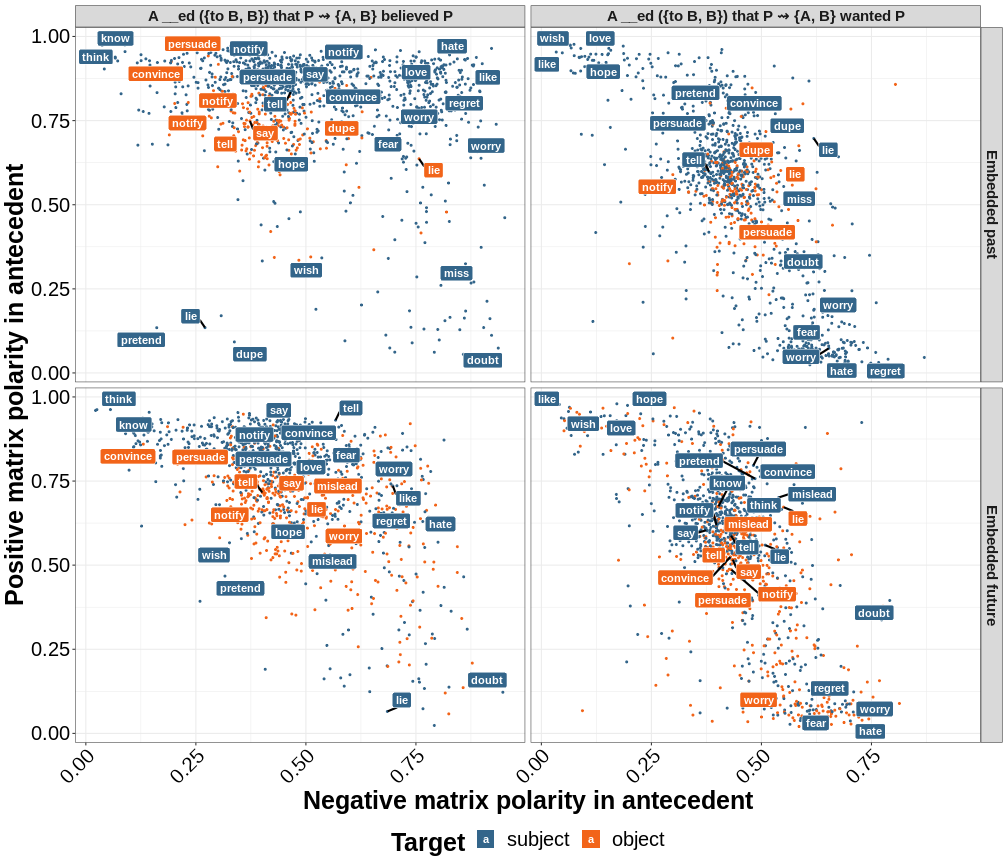

In [1783]:
%%R -i mc_normalized_cast_f -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

mc_normalized_cast_f$target <- factor(mc_normalized_cast_f$target, levels=c('subject', 'object'))
mc_normalized_cast_f$consequent_embedded_tense <- factor(mc_normalized_cast_f$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_f = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss')
transitive_verbs_f = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe')

intransitive_frames_f = c('NP V that S', 'NP be V that S', 
                          'NP V that S[+future]', 'NP be V that S[+future]', 
                          'NP V that S[-tense]', 'NP be V that S[-tense]')
transitive_frames_f = c('NP V to NP that S', 'NP V NP that S',
                        'NP V to NP that S[+future]', 'NP V NP that S[+future]',
                        'NP V to NP that S[-tense]', 'NP V NP that S[-tense]')

g <- ggplot(mc_normalized_cast_f, aes(x=negative, y=positive, color=target)) +
geom_point(size=0.75) +
geom_label_repel(data=filter(mc_normalized_cast_f, 
                       (antecedent_verb%in%intransitive_verbs_f & antecedent_frame %in% intransitive_frames_f) | (antecedent_verb%in%transitive_verbs_f & antecedent_frame %in% transitive_frames_f)), 
           aes(label=antecedent_verb, fill=target), 
           color="white", fontface="bold", segment.color="black", segment.size=1) +
scale_color_manual(name='Target', values=c("#33658a", "#f26419")) +
scale_fill_manual(name='Target',  values=c("#33658a", "#f26419")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) that P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', 'wanted'), 
                            ifelse(consequent_verb=='believe', 'P', 'P'))) +
xlab('Negative matrix polarity in antecedent') +
ylab('Positive matrix polarity in antecedent') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_distributions_finite.png', width=14, height=12)
ggsave('plots/verb_distributions_finite.pdf', width=14, height=12)

g

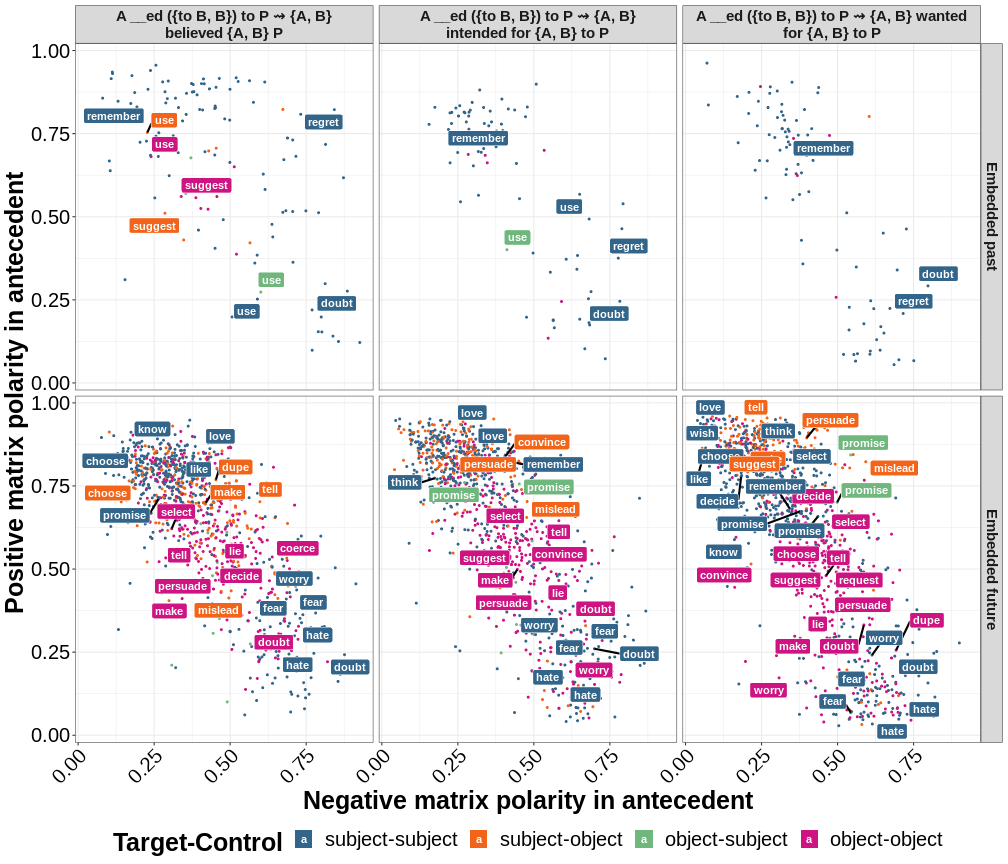

In [1784]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

sub <- filter(mc_normalized_cast_nf,
              (antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf))

g <- ggplot(mc_normalized_cast_nf, aes(x=negative, y=positive, color=target_control)) +
geom_point(size=0.75) +
geom_label_repel(data=sub, 
           aes(label=antecedent_verb, fill=target_control), 
           color="white", fontface="bold", segment.color="black", segment.size=1) +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P'))),
          labeller = label_wrap_gen(width = 40, multi_line = TRUE)) +
xlab('Negative matrix polarity in antecedent') +
ylab('Positive matrix polarity in antecedent') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_distributions_nonfinite.png', width=14, height=12)
ggsave('plots/verb_distributions_nonfinite.pdf', width=14, height=12)

g

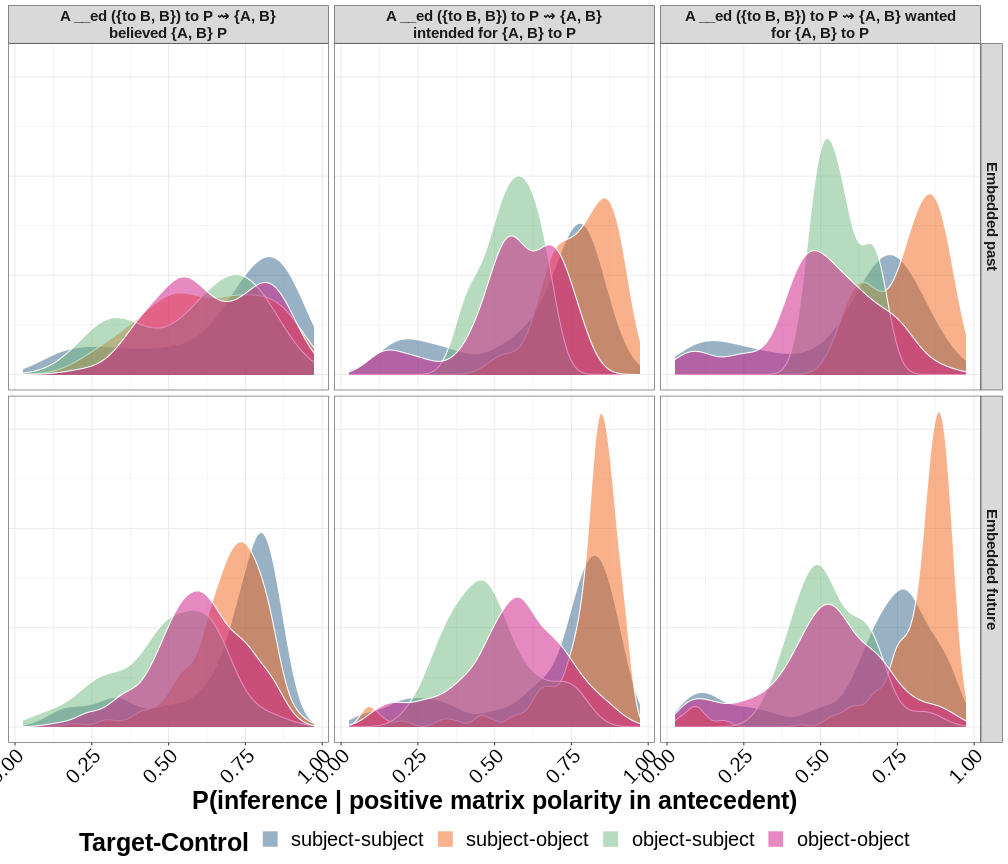

In [1785]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

sub <- filter(mc_normalized_cast_nf,
              ((antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf)))
sub$jit <- runif(nrow(sub), 0.25, 8)

g <- ggplot(mc_normalized_cast_nf, aes(x=positive, color=target_control)) +
geom_density(color="white", aes(fill=target_control), alpha=0.5) +
# geom_hline(yintercept=0) +
# geom_segment(data=sub, aes(x=positive, y=jit, xend=positive, yend=rep(0, length(jit)))) +
# geom_label(data=sub, aes(x=positive, y=jit, label=antecedent_verb, fill=target_control), fontface="bold", color="white") +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P'))),
          labeller = label_wrap_gen(width = 40, multi_line = TRUE)) +
xlab('P(inference | positive matrix polarity in antecedent)') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     axis.title.y = element_blank(),
     axis.text.y = element_blank(),
     axis.ticks.y = element_blank(),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_density_nonfinite_positive.png', width=14, height=12)
ggsave('plots/verb_density_nonfinite_positive.pdf', width=14, height=12)

g

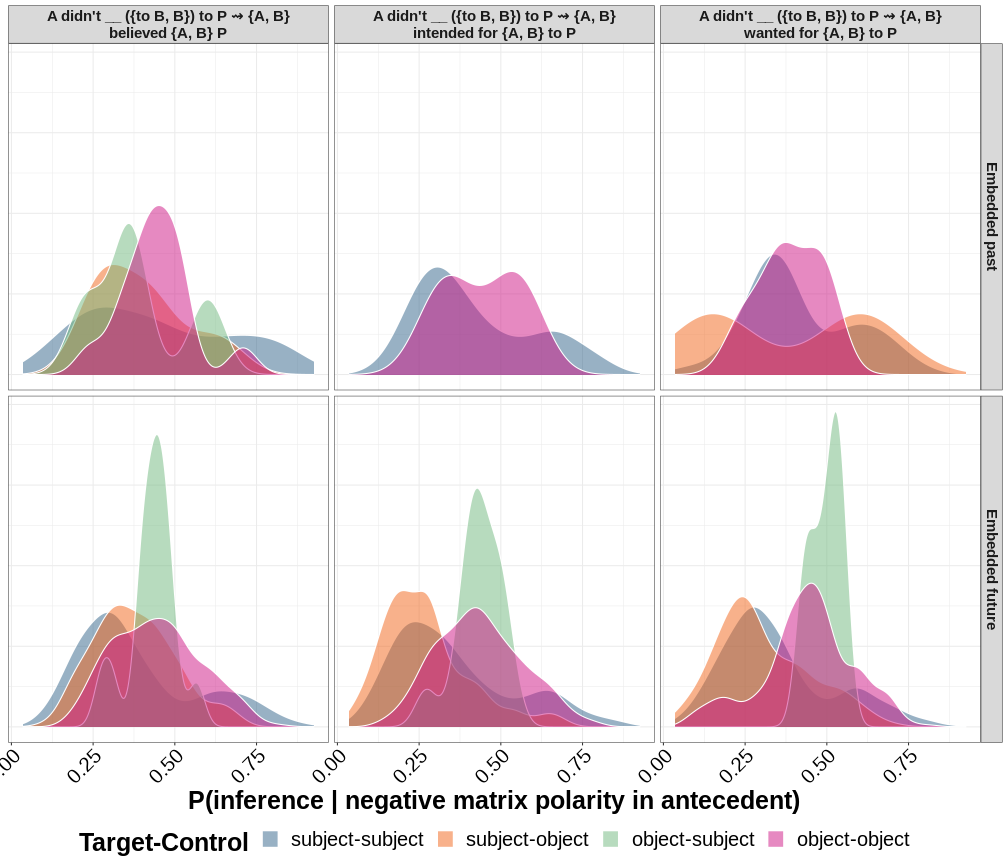

In [1786]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

sub <- filter(mc_normalized_cast_nf,
              ((antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf)))
sub$jit <- runif(nrow(sub), 0.25, 8)

g <- ggplot(mc_normalized_cast_nf, aes(x=negative, color=target_control)) +
geom_density(color="white", aes(fill=target_control), alpha=0.5) +
# geom_hline(yintercept=0) +
# geom_segment(data=sub, aes(x=negative, y=jit, xend=negative, yend=rep(0, length(jit)))) +
# geom_label(data=sub, aes(x=negative, y=jit, label=antecedent_verb, fill=target_control), fontface="bold", color="white") +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A didn\'t __ ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P'))),
          labeller = label_wrap_gen(width = 40, multi_line = TRUE)) +
xlab('P(inference | negative matrix polarity in antecedent)') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     axis.title.y = element_blank(),
     axis.text.y = element_blank(),
     axis.ticks.y = element_blank(),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_density_nonfinite_negative.png', width=14, height=12)
ggsave('plots/verb_density_nonfinite_negative.pdf', width=14, height=12)

g

## Discovering inference patterns

We apply a multiview mixed effects mixture model to three inference datasets and one syntactic acceptability dataset simultaneously: MegaIntensionality, MegaVeridicality, MegaNegRaising, and MegaAcceptability, respectively.

For each dataset, we define a `verb` column, which gives the verbs to be clustered, and an `item` column, which gives the dimensions of the cluster centers.

In the case of the inference datasets, we melt the antecedent frames into the `item` columns, so that each inference type is relativized to a particular frame. In the case of MegaAcceptability, the values of the `item` column are the frames. This allows us to cluster both types of datasets by verb using the same model.

For passive frames in the MegaIntensionality dataset, we again set target (and control, if any) to object

In [1787]:
mc.loc[mc['antecedent_frame'].isin(passive_frames), 'target'] = 'object'
mc.loc[(mc['antecedent_frame'].isin(passive_frames) & ~mc['control'].str.match('na')), 'control'] = 'object'

mc[mc['antecedent_frame'].isin(passive_frames)]

,participant,antecedent_verb,antecedent_polarity,target,control,antecedent_frame,consequent_verb,consequent_embedded_tense,antecedent_text,consequent_text,response,sanity,item
2,506,traumatize,negative,object,na,NP be V that S[+future],believe,future,A wasn't traumatized that C would happen,A believed that C would happen,0.67000,4,traumatize-negative-NP be V that S[+future]-su...
8,506,wager,positive,object,na,NP be V that S[+future],want,future,A was wagered that C would happen,A wanted C to happen,0.71000,4,wager-positive-NP be V that S[+future]-subject...
14,506,invigorate,positive,object,na,NP be V that S[+future],believe,future,A was invigorated that C would happen,A believed that C would happen,0.83000,4,invigorate-positive-NP be V that S[+future]-su...
19,506,trouble,negative,object,na,NP be V that S[+future],want,future,A wasn't troubled that C would happen,A wanted C to happen,0.50000,4,trouble-negative-NP be V that S[+future]-subje...
24,506,reaffirm,negative,object,na,NP be V that S[+future],believe,future,A wasn't reaffirmed that C would happen,A believed that C would happen,0.34000,4,reaffirm-negative-NP be V that S[+future]-subj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92616,335,suppose,positive,object,object,NP be V to VP[+eventive],believe,future,A was supposed to do C.,How likely is it that A believed that A would ...,0.79000,4,suppose-positive-NP be V to VP[+eventive]-subj...
92617,335,intrigue,negative,object,object,NP be V to VP[+eventive],want,future,A wasn't intrigued to do C.,How likely is it that A wanted to do C?,0.99999,4,intrigue-negative-NP be V to VP[+eventive]-sub...
92630,335,decree,positive,object,object,NP be V to VP[+eventive],want,future,A was decreed to do C.,How likely is it that A wanted to do C?,0.52000,4,decree-positive-NP be V to VP[+eventive]-subje...
92632,335,aim,positive,object,object,NP be V to VP[+eventive],believe,future,A was aimed to do C.,How likely is it that A believed that A would ...,0.93000,4,aim-positive-NP be V to VP[+eventive]-subject-...


In [1788]:
mc['verb'] = mc.antecedent_verb

mc['item'] = (mc.antecedent_polarity + '-' +
              mc.target + '-' +
              mc.control + '-' +
              mc.consequent_verb + '-' +
              mc.antecedent_frame)

mc

,participant,antecedent_verb,antecedent_polarity,target,control,antecedent_frame,consequent_verb,consequent_embedded_tense,antecedent_text,consequent_text,response,sanity,item,verb
0,506,fess_up,negative,object,na,NP V to NP that S[+future],want,future,A didn't fess up to B that C would happen,B wanted C to happen,0.38000,4,negative-object-na-want-NP V to NP that S[+fut...,fess_up
1,506,consider,positive,subject,na,NP V that S,want,past,A considered that C happened,A wanted C to have happened,0.78000,4,positive-subject-na-want-NP V that S,consider
2,506,traumatize,negative,object,na,NP be V that S[+future],believe,future,A wasn't traumatized that C would happen,A believed that C would happen,0.67000,4,negative-object-na-believe-NP be V that S[+fut...,traumatize
3,506,speculate,positive,object,na,NP V to NP that S[+future],believe,future,A speculated to B that C would happen,B believed that C would happen,0.63000,4,positive-object-na-believe-NP V to NP that S[+...,speculate
4,506,blare,positive,subject,na,NP V that S[-tense],want,future,A blared that C happen,A wanted C to happen,0.86000,4,positive-subject-na-want-NP V that S[-tense],blare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92635,335,cause,negative,subject,object,NP V NP to VP[+eventive],believe,future,A didn't cause B to do C.,How likely is it that A believed that B would ...,0.29000,4,negative-subject-object-believe-NP V NP to VP[...,cause
92636,335,perceive,positive,object,object,NP V NP to VP[+eventive],intend,future,A perceived B to do C.,How likely is it that B intended to do C?,0.50000,4,positive-object-object-intend-NP V NP to VP[+e...,perceive
92637,335,steer,negative,object,object,NP V NP to VP[+eventive],intend,future,A didn't steer B to do C.,How likely is it that B intended to do C?,0.50000,4,negative-object-object-intend-NP V NP to VP[+e...,steer
92638,335,sign_on,positive,subject,subject,NP V to VP[+eventive],intend,future,A signed on to do C.,How likely is it that A intended to do C?,0.99999,4,positive-subject-subject-intend-NP V to VP[+ev...,sign_on


In addition to MegaIntensionality, we use [MegaVeridicality](http://megaattitude.io/projects/mega-veridicality/), which captures veridicality inferences using 3-way ordinal judgments (_yes_, _maybe or maybe not_, _no_)...

In [1789]:
mv = pd.read_csv('http://megaattitude.io/projects/mega-veridicality/mega-veridicality-v2/mega-veridicality-v2.csv')

mv = mv[mv.veridicality.notna()]
mv = mv[mv.nativeenglish]
mv = mv[~mv.conditional]

mv['frame'] = mv.frame + '-' + mv.voice
mv['frame'] = mv.frame.map({'that_S-active': 'NP V that S',
                            'that_S-passive': 'NP be V that S',
                            'to_VPeventive-active': 'NP V to VP[+eventive]',
                            'NP_to_VPeventive-active': 'NP V NP to VP[+eventive]',
                            'to_VPstative-active': 'NP V to VP[-eventive]',
                            'NP_to_VPstative-active': 'NP V NP to VP[-eventive]',
                            'to_VPeventive-passive': 'NP be V to VP[+eventive]',
                            'to_VPstative-passive': 'NP be V to VP[-eventive]',
                            'for_NP_to_VP-active': 'NP V for NP to VP'})

# mv['verb'] = mv.verb

mv['item'] = mv.polarity + '-' + mv.frame

mv['response'] = mv.veridicality.astype(pd.CategoricalDtype(categories=['no', 'maybe', 'yes'])).cat.codes

mv

,participant,list,presentationorder,verb,frame,voice,polarity,conditional,sentence,veridicality,acceptability,nativeenglish,exclude,item,response
0,487,0,1,surmise,NP V that S,active,positive,False,Someone surmised that a particular thing happened,maybe,6,True,False,positive-NP V that S,1
1,487,0,2,update,NP V that S,active,positive,False,Someone updated that a particular thing happened,yes,2,True,False,positive-NP V that S,2
2,487,0,3,disregard,NP V that S,active,negative,False,Someone didn\'t disregard that a particular th...,maybe,4,True,False,negative-NP V that S,1
3,487,0,4,agree,NP V that S,active,positive,False,Someone agreed that a particular thing happened,yes,4,True,False,positive-NP V that S,2
4,487,0,5,surmise,NP V that S,active,negative,False,Someone didn\'t surmise that a particular thin...,maybe,3,True,False,negative-NP V that S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50255,127,81,53,compel,NP V NP to VP[-eventive],active,negative,False,Someone didn\'t compel a particular person to ...,maybe,5,True,False,negative-NP V NP to VP[-eventive],1
50256,127,81,54,decline,NP V to VP[-eventive],active,negative,False,A particular person didn\'t decline to have a ...,yes,6,True,False,negative-NP V to VP[-eventive],2
50257,127,81,55,advise,NP V NP to VP[+eventive],active,positive,False,Someone advised a particular person to do a pa...,maybe,7,True,False,positive-NP V NP to VP[+eventive],1
50258,127,81,56,approve,NP be V to VP[-eventive],passive,positive,False,A particular person was approved to have a par...,yes,7,True,False,positive-NP be V to VP[-eventive],2


...and [MegaNegRaising](http://megaattitude.io/projects/mega-negraising), which captures neg-raising inferences using a [0, 1] slider (like MegaIntensionality)...

In [1790]:
mn = pd.read_csv('http://megaattitude.io/projects/mega-negraising/mega-negraising-v1/mega-negraising-v1.tsv', sep='\t')

mn = mn[mn.nativeenglish]

# mn['verb'] = mn.verb

mn['item'] = mn.subject + '-' + mn.tense + '-' + mn.frame

mn['response'] = mn.negraising.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

mn

,participant,list,presentationorder,verb,frame,tense,subject,sentence1,sentence2,negraising,acceptability,nativeenglish,item,response
0,229,81,8,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.30,0.97,True,first-past-NP V that S,0.30000
1,259,81,15,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.09,0.34,True,first-past-NP V that S,0.09000
2,883,81,14,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.50,0.71,True,first-past-NP V that S,0.50000
3,665,81,22,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.00,0.87,True,first-past-NP V that S,0.00001
4,901,81,12,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.33,0.61,True,first-past-NP V that S,0.33000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79355,723,45,9,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.23,0.35,True,third-past-NP V to VP[+eventive],0.23000
79356,416,45,2,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.26,0.00,True,third-past-NP V to VP[+eventive],0.26000
79357,314,45,30,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.25,0.41,True,third-past-NP V to VP[+eventive],0.25000
79358,939,45,32,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.82,0.77,True,third-past-NP V to VP[+eventive],0.82000


...and [MegaAcceptability](http://megaattitude.io/projects/mega-acceptability/), which captures syntactic acceptability judgments for verbs in particular frames using 7-way ordinal judgments.

In [1791]:
ma = pd.read_csv('http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v2/mega-acceptability-v2.tsv', sep='\t')

ma = ma[ma.response.notna()]
ma = ma[ma.nativeenglish]

ma['frame'] = ma.frame.str.replace('Ved', 'V')
ma['frame'] = ma.frame.str.replace('was V', 'be V')

# keep_frames = list(set(list(mc.antecedent_frame.unique()) +
#                        list(mv.frame.unique()) +
#                        list(mn.frame.unique())))
# ma = ma[ma.frame.isin(keep_frames)]

# for x in keep_frames:
#     if x not in ma.frame.unique():
#         print(x)

# # ma['verb'] = ma.verb

ma['item'] = ma.tense + '-' + ma.frame

ma['response'] = ma.response.astype(int)-1

ma

,participant,list,presentationorder,verb,frame,tense,response,nativeenglish,sentence,version,item
0,192,504,13,abhor,NP V,past,6,True,Someone abhorred.,1,past-NP V
1,638,504,13,abhor,NP V,past,2,True,Someone abhorred.,1,past-NP V
2,200,504,13,abhor,NP V,past,0,True,Someone abhorred.,1,past-NP V
3,336,504,13,abhor,NP V,past,2,True,Someone abhorred.,1,past-NP V
4,339,504,13,abhor,NP V,past,3,True,Someone abhorred.,1,past-NP V
...,...,...,...,...,...,...,...,...,...,...,...
374995,297,821,18,yelp,"S, I V",present,0,True,"Something happened, I yelp.",1,"present-S, I V"
374996,248,821,18,yelp,"S, I V",present,1,True,"Something happened, I yelp.",1,"present-S, I V"
374997,430,821,18,yelp,"S, I V",present,0,True,"Something happened, I yelp.",1,"present-S, I V"
374998,557,821,18,yelp,"S, I V",present,6,True,"Something happened, I yelp.",1,"present-S, I V"


### Combining the datasets

To make passing multiple datasets (with metadata) to the mixture model we define below, we use a lightweight dataclass.

In [1792]:
@dataclass
class Data:
    dataframe: pd.DataFrame
    name: str
    datatype: str
        
data = [Data(mc, 'belief_desire', 'unit'), 
        Data(mv, 'veridicality', 'ordinal'),
        Data(mn, 'negraising', 'unit'),
        Data(ma, 'acceptability', 'ordinal')]

### KMeans Initialization

In the following cells we define the multiview mixture model, which is initialized using a variant of $k$-means clustering that allows for missing data.

In [1793]:
class KMeansWithMissingData:
    """K-Means for data with values missing
    
    Parameters
    ----------
    n_clusters
        The number of clusters.
    init
        How to initialize the model. Must be either "random" (default) 
        or "kmeans++".
    fuzzy_impute
        Whether to use hard (default) or fuzzy imputation when imputing 
        missing values during cluster center updates.
    random_state
        The random seed.
    """
    
    def __init__(self, n_clusters: int = 2, init: str="random", 
                 fuzzy_impute: bool = False, random_state: int = 42):
        self.n_clusters = n_clusters
        self.init_method = init
        self.fuzzy_impute = fuzzy_impute
        self.random_state = random_state
    
    def _initialize_cluster_centers(self):
        self.missing_patterns_, self.pattern_assignments_ = np.unique(self.missing_, 
                                                                      return_inverse=True,
                                                                      axis=0)
        self.observed_patterns_ = ~self.missing_patterns_
        
        self.X_binned_ = [self.X_[self.pattern_assignments_ == i] 
                          for i in range(self.missing_patterns_.shape[0])]
        
        X_synthesized = np.array([np.nanmean([b[np.random.choice(b.shape[0])]
                                              for b in self.X_binned_], axis=0) 
                                  for _ in range(self.X_.shape[0])])
        
        if self.init_method == "kmeans++":
            cluster_centers = np.array([X_synthesized[0]])

            for _ in range(self.n_clusters-1):
                dist = np.square(cluster_centers[:,None,:] -
                                 X_synthesized[None,:,:]).sum(axis=2)
                mindist = dist.min(axis=0)
                prob = mindist/mindist.sum()

                center = X_synthesized[np.random.choice(prob.shape[0], p=prob)]

                cluster_centers = np.concatenate([cluster_centers, [center]], axis=0)
                
        else:
            cluster_centers = X_synthesized[:self.n_clusters]

        self.cluster_centers_ = cluster_centers
    
    def _compute_cluster_assignments(self, X=None, cluster_centers=None):
        self.sqdist_to_center_ = self._compute_distances(X=X,
                                                         cluster_centers=cluster_centers)
        self.cluster_assignments_ = np.argmin(self.sqdist_to_center_, axis=0)
    
    def _compute_distances(self, X=None, cluster_centers=None):
        if X is None:
            X = self.X_
        
        if cluster_centers is None:
            cluster_centers = self.cluster_centers_
        
        return np.nansum(np.square(cluster_centers[:,None,:] - X[None,:,:]), 
                         axis=2)
    
    def _impute(self):
        if self.fuzzy_impute:
            weight = np.exp(-self.sqdist_to_center_)/\
                     np.exp(-self.sqdist_to_center_).sum(axis=0)[None,:]
            
            return np.where(self.missing_, 
                            np.sum(weight[:,:,None]*
                                   self.cluster_centers_[:,None,:], 
                                   axis=0), 
                            self.X_)
        else:
            return np.where(self.missing_, 
                            self.cluster_centers_[self.cluster_assignments_], 
                            self.X_)    
    
    def fit(self, X: np.array, maxiter=1000):
        """Computes a modified version of Lloyd's algorithm

        The main difference between the standard version of Lloyd's algorithm 
        and the one computed here is that, when computing the distance between 
        a point and a cluster center, only the observed values for the point 
        are used; and when updating cluster centers, the missing values for 
        a point are first imputed based either on the current cluster assignment 
        (hard imputation) or as a weighted mean over a softmax on the negative 
        distances.

        Parameters
        ----------
        X
            The points to cluster
        maxiter
            The maximum number of EM iterations
        """
        self.X_ = X
        self.n_samples_, self.n_features_ = self.X_.shape
        
        # find the missing values
        self.missing_ = np.isnan(self.X_)
        self.observed_ = ~self.missing_
        
        # initialize cluster centers
        np.random.seed(self.random_state)
        self._initialize_cluster_centers()
        
        # initialize cluster assignments
        self._compute_cluster_assignments()
        
        for _ in range(maxiter):
            previous_cluster_assignments = self.cluster_assignments_

            # impute missing values based on current assignments
            Ximputed = self._impute()
            
            # update cluster centers
            for i in np.arange(self.n_clusters):
                Ximputed_i = Ximputed[self.cluster_assignments_ == i]
                self.cluster_centers_[i] = np.mean(Ximputed_i, axis=0)
                
            # update cluster assignments
            self._compute_cluster_assignments()
            
            # test change in cluster assignments
            cluster_assignment_unchanged = (previous_cluster_assignments ==
                                            self.cluster_assignments_)

            if cluster_assignment_unchanged.all():
                break
            
        else:
            warn(f'KMeansWithMissingData({self.n_clusters}) did not converge'
                 f' after {maxiter} iterations')
        
        return self
    
    def distances(self, X):
        return self._compute_distances(X=X)
    
    def sse(self, X):
        agg = 0.
        distances = self.distances(X)
        assignments = self.cluster_assignments_
        for c in range(self.n_clusters):
            dc = distances[c][np.where(assignments == c)]
            agg += np.sum(np.square(dc))
        return agg
    
    
def compute_kmeans_best_fit(X: np.array, n_clusters: int = 2,
                            init: str="random", fuzzy_impute: bool = False, random_state: int = 42,
                            maxiter=1000, num_trials=1, verbosity=20):
    """Attempts to fit K-Means `num_trials` times, returning the result with the lowest squared error."""
    min_kmeans = None
    min_sse = np.inf
    np.random.seed(random_state)
    seeds = np.random.randint(0, 10000, size=num_trials)
    for trial in range(num_trials):
        if trial % verbosity == 0:
            print(f'Computing KMeans initialization with minimum squared error; current minimum: {min_sse}')
        kmeans = KMeansWithMissingData(n_clusters=n_clusters, init=init, fuzzy_impute=fuzzy_impute, random_state=seeds[trial])
        kmeans.fit(X, maxiter=maxiter)
        sse = kmeans.sse(X)
        if min_kmeans is None or sse < min_sse:
            min_kmeans = kmeans
            min_sse = sse
    return min_kmeans

### Response Models

Each "view" of the data is modeled using either a unit mixed effects model or an ordinal mixed effects model, depending on the response type of that dataset.

TODO: add descriptions for unit and ordinal models

In [1794]:
def truncated_normal_log_prob(x, mu, sigma, a, b):
    """Compute the log-likelihood of `x` from a truncated normal distribution."""
    normal = dist.Normal(mu, sigma)
    return normal.log_prob(x) - torch.log(normal.cdf(torch.tensor(b)) - normal.cdf(torch.tensor(a)))
    

class UnitMixedEffectsModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, name, n_components, n_verb, n_item, n_participant, locs_init=None,
                 large_variance=100, location_variance=1., hyperpriors=False):
        super(UnitMixedEffectsModel, self).__init__()
        
        self.name = name
        self.n_components = n_components
        self.n_verb = n_verb
        self.n_item = n_item
        self.n_participant = n_participant
        
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.hyperpriors = hyperpriors

        # hyperparameters
        if self.hyperpriors:
            self.locs_variance = nn.Parameter(torch.empty(1))
            self.locs_participant_variance = nn.Parameter(torch.empty(1))
        
        # parameters
        self.theta = nn.Parameter(torch.empty(3, self.n_components, self.n_item))
        self.theta_participant = nn.Parameter(torch.empty(3, self.n_participant))
        self.locs = nn.Parameter(torch.empty(self.n_components, self.n_item))
        self.locs_participant = nn.Parameter(torch.empty(self.n_participant))

        # initialization
        if self.hyperpriors:
            self._init_uniform(self.locs_variance)
            self._init_uniform(self.locs_participant_variance)
        self._init_uniform(self.theta)
        self._init_uniform(self.theta_participant)
        if locs_init is not None:
            self.locs.data = torch.tensor(locs_init).type(torch.float)
        else:
            self._init_uniform(self.locs)
        self._init_uniform(self.locs_participant)
        
        self.softmax = torch.nn.Softmax(dim=0)
        self.logsoftmax = torch.nn.LogSoftmax(dim=0)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
        
    def forward(self, verb, item, participant, response):
        return self._likelihood(verb, item, participant, response) + self._prior()
    
    def _likelihood(self, verb, item, participant, response):        
        # (3, n_components, n_response)
        theta = self.logsoftmax(self.theta[:, :, item] + self.theta_participant[:, participant].unsqueeze(1))
        
        # (n_components, n_response)
        locs = torch.sigmoid(self.locs[:, item] + self.locs_participant[participant])
        
        ones = torch.ones((self.n_components, len(response)))
        zeros = torch.zeros((self.n_components, len(response)))
        
        # (n_components, n_response)
        llike_1 = truncated_normal_log_prob(response, ones, self.location_variance, 0, 1)
        llike_0 = truncated_normal_log_prob(response, zeros, self.location_variance, 0, 1)
        llike_prior = truncated_normal_log_prob(response, locs, self.location_variance, 0, 1)
        
        # (3, n_components, n_response)
        llike_parts = torch.stack((llike_1, llike_0, llike_prior))
        
        # (n_components, n_response)
        lp = torch.logsumexp(theta + llike_parts, dim=0)
        
        return lp
    
    def _prior(self):
        if self.hyperpriors:
            lp_locs_variance = dist.LogNormal(np.log(self.location_variance), self.large_variance).log_prob(self.locs_variance.exp().clamp(max=INF))
            lp_locs_participant_variance = dist.LogNormal(0., self.large_variance).log_prob(self.locs_participant_variance.exp().clamp(max=INF))
        
            lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.locs_variance.exp().clamp(max=INF)*torch.eye(self.n_item)).log_prob(self.locs).sum()
            lp_locs_participant = dist.Normal(0., self.locs_participant_variance.exp().clamp(max=INF)).log_prob(self.locs_participant).sum()
            
        else:
            lp_locs_variance = torch.tensor(0.)
            lp_locs_participant_variance = torch.tensor(0.)
            
            lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.large_variance*torch.eye(self.n_item)).log_prob(self.locs).sum()
            lp_locs_participant = dist.Normal(0., self.large_variance).log_prob(self.locs_participant).sum()
        
        lp = lp_locs_variance + lp_locs_participant_variance + lp_locs + lp_locs_participant

        return lp
    
    def _locs(self):
        return torch.sigmoid(self.locs)
    
    def _theta(self):
        return self.softmax(self.theta)
    
    
class OrdMixedEffectsModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, name, n_components, n_verb, n_item, n_participant, n_response_types, locs_init=None,
                 large_variance=100, location_variance=1., hyperpriors=False):
        super(OrdMixedEffectsModel, self).__init__()

        self.name = name
        self.n_components = n_components
        self.n_verb = n_verb
        self.n_item = n_item
        self.n_participant = n_participant
        self.n_response_types = n_response_types
        
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.hyperpriors = hyperpriors
        
        # hyperparameters
        if self.hyperpriors:
            self.locs_variance = nn.Parameter(torch.empty(1))
            self.shift_variance = nn.Parameter(torch.empty(1))

        # parameters
        self.locs = nn.Parameter(torch.empty(self.n_components, self.n_item))
        self.jumps = nn.Parameter(torch.empty(self.n_response_types-1))
        self.shift_participant = nn.Parameter(torch.empty(self.n_participant))

        # initialization
        if self.hyperpriors:
            self._init_uniform(self.locs_variance)
            self._init_uniform(self.shift_variance)
        if locs_init is not None:
            self.locs.data = torch.tensor(locs_init).type(torch.float)
        else:
            self._init_uniform(self.locs)
        self._init_uniform(self.jumps)
        self._init_uniform(self.shift_participant)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
        
    def forward(self, verb, item, participant, response):
        return self._likelihood(verb, item, participant, response) + self._prior()
    
    def _likelihood(self, verb, item, participant, response):
        cuts = torch.cumsum(torch.exp(self.jumps), axis=0)
        cuts_participant = cuts + self.shift_participant.unsqueeze(-1)
        # cuts_participant = cuts_participant - torch.mean(cuts_participant)
        
        values = torch.cat((self.n_response_types - 1)*[self.locs[:,item].unsqueeze(-1)], axis=-1)
        
        cdf = torch.sigmoid(cuts_participant[participant] - values)
        cdf_pad_shape = list(cdf.shape[:-1])+[1]
        cdf_high = torch.cat([cdf, torch.ones(cdf_pad_shape)], axis=-1)
        cdf_low = torch.cat([torch.zeros(cdf_pad_shape), cdf], axis=-1)
        
        pmf = cdf_high - cdf_low
        
        # (n_components, n_response)
        lp = dist.Categorical(probs=pmf).log_prob(response)
        
        return lp
    
    def _prior(self):
        if self.hyperpriors:
            lp_locs_variance = dist.LogNormal(np.log(self.location_variance), self.large_variance).log_prob(self.locs_variance.exp().clamp(max=INF))
            lp_shift_variance = dist.LogNormal(0., self.large_variance).log_prob(self.shift_variance.exp().clamp(max=INF))
            
            lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.locs_variance.exp().clamp(max=INF)*torch.eye(self.n_item)).log_prob(self.locs).sum()
            lp_shift_participant = dist.Normal(0., self.shift_variance.exp().clamp(max=INF)).log_prob(self.shift_participant).sum()
            
        else:
            lp_locs_variance = torch.tensor(0.)
            lp_shift_variance = torch.tensor(0.)
            
            lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.large_variance*torch.eye(self.n_item)).log_prob(self.locs).sum()
            lp_shift_participant = dist.Normal(0., self.large_variance).log_prob(self.shift_participant).sum()

        lp_jumps = dist.MultivariateNormal(torch.zeros(self.n_response_types - 1),
                                           self.large_variance*torch.eye(self.n_response_types - 1)).log_prob(self.jumps)
        
        lp = lp_locs_variance + lp_locs + lp_jumps + lp_shift_variance + lp_shift_participant
        
        return lp
    
    def _locs(self):
        return self.locs
    
    def _jumps(self):
        return self.jumps

### Multiview LDA Model

The LDA mixture model assumes that each verb has a set of categorical weights across each component, with the weights being distributed according to a dirichlet prior. The distributional assumptions are as follows:

$$\begin{align*}
\alpha &\sim \mathrm{log}\mathcal{N}(0,100) \\
\boldsymbol\gamma &\sim \mathrm{Dirichlet}\left(\mathbf{1}_K\right) \\
\boldsymbol\theta_v &\sim \mathrm{Dirichlet}\left(\alpha \mathbf{\gamma}\right) \\
z_{i} &\sim \mathrm{Categorical}\left(\boldsymbol\theta_{\mathrm{verb}(i)}\right) \\
\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_i\right\rangle} & \sim \mathcal{N}(\mathbf{0}, 100\mathbf{I}) \\
y_i &\sim f_{\mathrm{view}(i)}\left(\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_i\right\rangle} \cdot \mathbf{x}_i, \boldsymbol\rho_{\mathrm{participant}(i)}\right) \\
\end{align*}$$

where $f_{\mathrm{view}(i)}$ is an ordinal mixed effects model for MegaVeridicality and MegaAcceptability responses, and a unit mixed effects model for MegaNegRaising and MegaIntensionality responses.

We fit the model using MAP estimation. The posterior is as follows:

$$
\begin{align}
P(\boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi \mid \mathbf{r}) \propto P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{d} \prod_{n} P(r_{n}^{(d)} \mid \boldsymbol\theta_{\mathrm{verb}(n)}, \boldsymbol\phi, \boldsymbol\psi) \\
%
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{d} \prod_{n} \sum_{c} P(z_{n} = c \mid \boldsymbol\theta_{\mathrm{verb}(n)}) P(r_{n}^{(d)} \mid z_{n} = c, \boldsymbol\phi, \boldsymbol\psi) \\
%
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{d} \prod_{n} \sum_{c} P(z_{n} = c \mid \boldsymbol\theta_{\mathrm{verb}(n)}) f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \\
%
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{d} \prod_{n} \sum_{c} \theta_{\mathrm{verb}(n),c}  f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)
\end{align}
$$

Computing the loss function for MAP:

$$
\begin{align}
\mathcal{L} &= - \log P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \log \prod_{d} \prod_{n} \sum_{c} \theta_{\mathrm{verb}(n),c}  f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{d} \sum_{n} \log \sum_{c} \theta_{\mathrm{verb}(n),c}  f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{d} \sum_{n} \log \sum_{c} e^{\log \left(\theta_{\mathrm{verb}(n),c} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)\right)} \right] \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{d} \sum_{n} \underset{c}{\mathrm{logsumexp}} \left[ \log \theta_{\mathrm{verb}(n),c} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{d} \sum_{n} \underset{c}{\mathrm{logsumexp}} \left[ \log \theta_{\mathrm{verb}(n),c} +  \log f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
\end{align}
$$

In [1795]:
class MultiviewLDAModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, n_components, n_verb, datatypes, categories, initialization={},
                     infer_weight_component_dispersion=False, infer_weight_mean=False,
                     large_variance=100, component_dispersion=1., location_variance=1.,
                     weight_regularization=0., hyperpriors=False):
        super(MultiviewLDAModel, self).__init__()

        self.n_components = n_components
        self.n_verb = n_verb

        self.infer_weight_component_dispersion = infer_weight_component_dispersion
        self.infer_weight_mean = infer_weight_mean

        self.component_dispersion = component_dispersion
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.weight_regularization = weight_regularization
        
        self.hyperpriors = hyperpriors

        # hyperparameters
        if self.infer_weight_component_dispersion:
            self.weight_component_dispersion = nn.Parameter(torch.empty(1))
        if self.infer_weight_mean:
            self.weight_mean = nn.Parameter(torch.empty(self.n_components))

        # parameters
        self.weights = nn.Parameter(torch.empty(self.n_verb, self.n_components))

        # initialization
        if self.infer_weight_component_dispersion:
            self._init_uniform(self.weight_component_dispersion)
        if self.infer_weight_mean:
            self._init_uniform(self.weight_mean)
        if 'weights' in initialization:
            self.weights.data = torch.tensor(initialization['weights']).type(torch.float)
        else:
            self._init_uniform(self.weights)
                
        self.softmax = torch.nn.Softmax(dim=-1)
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)
        
        # mixed effects models
        model_dict = {}
        for name in categories:
            locs_init = initialization[f'{name}_locs'] if f'{name}_locs' in initialization else None
            
            n_item = len(categories[name]['item'])
            n_participant = len(categories[name]['participant'])
            
            if datatypes[name] == 'unit':
                model_dict[name] = UnitMixedEffectsModel(name, self.n_components, self.n_verb, n_item, n_participant, locs_init=locs_init,
                                                         location_variance=self.location_variance, hyperpriors=self.hyperpriors)
                
            elif datatypes[name] == 'ordinal':
                n_response_types = len(categories[name]['response'])
                model_dict[name] = OrdMixedEffectsModel(name, self.n_components, self.n_verb, n_item, n_participant, n_response_types, locs_init=locs_init,
                                                        location_variance=self.location_variance, hyperpriors=self.hyperpriors)
        self.model_dict = nn.ModuleDict(model_dict)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
    
    def forward(self, data):
        return -(self._likelihood(data) + self._prior())

    def _likelihood(self, data):
        lp = torch.tensor(0.)
        
        for name, d in data.items():
            # (n_components, n_response)
            lp_response = self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])
            
            # (n_response, n_components)
            lp_r = self.logsoftmax(self.weights[d['verb']]) + lp_response.T
            
            # (n_response,)
            lp_r = lp_r.logsumexp(dim=-1)
            
            lp.add_(lp_r.sum())
        
        return lp
    
    def _prior(self):
        lp_weight_component_dispersion = 0.
        if self.infer_weight_component_dispersion:
            weight_component_dispersion = self.weight_component_dispersion.exp().clamp(max=INF)
            lp_weight_component_dispersion = dist.LogNormal(np.log(self.component_dispersion), self.large_variance).log_prob(weight_component_dispersion)
        else:
            weight_component_dispersion = self.component_dispersion
        
        lp_weight_mean = 0.
        if self.infer_weight_mean:
            weight_mean = self.softmax(self.weight_mean)
            lp_weight_mean = dist.Dirichlet(torch.ones(self.n_components)).log_prob(weight_mean)
            theta = self.n_components * weight_mean
        else:
            theta = torch.ones(self.n_components)
        
        lp_weights_l2 = self.weight_regularization * dist.Normal(0, 1).log_prob(self.weights).sum()
        lp_weights = dist.Dirichlet(weight_component_dispersion*theta).log_prob(self.softmax(self.weights).clamp(min=1.0000e-30, max=1.0000e+00)).sum()
        
        lp = lp_weight_component_dispersion + lp_weight_mean + lp_weights + lp_weights_l2
        for model in self.model_dict.values():
            lp += model._prior().reshape(())
        
        return lp
    
    def _likelihood_per_item(self, data, views=None):
        lp = torch.zeros(self.n_verb)

        for name, d in data.items():
            if views is None or name in views:
                # (n_components, n_response)
                lp_response = self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])
                
                # (n_response, n_components)
                lp_r = self.logsoftmax(self.weights[d['verb']]) + lp_response.T

                # (n_response,)
                lp_r = lp_r.logsumexp(dim=-1)
            
                # (n_verb,)
                lp.index_add_(0, d['verb'], lp_r)
                
        return lp
    
    def _membership_probabilities(self, data):
        return self.softmax(self.weights)

### Multiview Mixture Model

The multiview mixture model assumes that each verb is a member of some component, i.e., $z_v = c$, with the component memberships being drawn from a single categorical distribution. The distributional assumptions are as follows:

$$\begin{align*}
\boldsymbol\theta &\sim \mathrm{Dirichlet}\left(\gamma \mathbf{1}_K\right) \\
z_{v} &\sim \mathrm{Categorical}\left(\boldsymbol\theta\right) \\
\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_{\mathrm{verb}(i)}\right\rangle} & \sim \mathcal{N}(\mathbf{0}, 100\mathbf{I}) \\
y_i &\sim f_{\mathrm{view}(i)}\left(\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_{\mathrm{verb}(i)}\right\rangle} \cdot \mathbf{x}_i, \boldsymbol\rho_{\mathrm{participant}(i)}\right) \\
\end{align*}$$

where $f_{\mathrm{view}(i)}$ is an ordinal mixed effects model for MegaVeridicality and MegaAcceptability responses, and a unit mixed effects model for MegaNegRaising and MegaIntensionality responses.

We fit the model using MAP estimation. The posterior is as follows:

$$
\begin{align}
P(\boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi \mid \mathbf{r}) \propto P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{v} P(\mathbf{r}_{v} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{v} \sum_{c} P(z_{v} = c \mid \boldsymbol\theta) P(\mathbf{r}_{v} \mid z_{v} = c, \boldsymbol\phi, \boldsymbol\psi) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{v} \sum_{c} P(z_{v} = c \mid \boldsymbol\theta) \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{v} \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)
\end{align}
$$

Computing the loss function for MAP:

$$
\begin{align}
\mathcal{L} &= - \log P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \log \prod_{v} \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{v} \log \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{v} \log \sum_{c} e^{\log \left(\theta_c \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)\right)} \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{v} \underset{c}{\mathrm{logsumexp}} \left[ \log(\theta_c) + \log \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{v} \underset{c}{\mathrm{logsumexp}} \left[ \log(\theta_c) + \sum_{d} \sum_{\{n | \mathrm{verb}(n) = v\}} \log f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
\end{align}
$$

In [1796]:
class MultiviewMixtureModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, n_components, n_verb, datatypes, categories, initialization={},
                 large_variance=100, component_dispersion=1., location_variance=1., hyperpriors=False):
        super(MultiviewMixtureModel, self).__init__()
        
        self.n_components = n_components
        self.n_verb = n_verb
        
        self.component_dispersion = component_dispersion
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.hyperpriors = hyperpriors
        
        # parameters
        self.weights = nn.Parameter(torch.empty(self.n_components))
        
        # initialization
        if 'weights' in initialization:
            self.weights.data = torch.tensor(initialization['weights']).type(torch.float)
        else:
            self._init_uniform(self.weights)
        
        self.softmax = torch.nn.Softmax(dim=0)
        
        # mixed effects models
        model_dict = {}
        for name in categories:
            locs_init = initialization[f'{name}_locs'] if f'{name}_locs' in initialization else None
            
            n_item = len(categories[name]['item'])
            n_participant = len(categories[name]['participant'])
            
            if datatypes[name] == 'unit':
                model_dict[name] = UnitMixedEffectsModel(name, self.n_components, self.n_verb, n_item, n_participant, locs_init=locs_init,
                                                         location_variance=self.location_variance, hyperpriors=self.hyperpriors)
                
            elif datatypes[name] == 'ordinal':
                n_response_types = len(categories[name]['response'])
                model_dict[name] = OrdMixedEffectsModel(name, self.n_components, self.n_verb, n_item, n_participant, n_response_types, locs_init=locs_init,
                                                        location_variance=self.location_variance, hyperpriors=self.hyperpriors)
        self.model_dict = nn.ModuleDict(model_dict)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
    
    def forward(self, data):
        return -(self._likelihood(data) + self._prior())
    
    def _likelihood(self, data):
        # (n_components, n_verb)
        lp_vf = torch.zeros((self.n_components, self.n_verb))
        
        for name, d in data.items():
            # (n_components, n_response)
            lp_response = self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])
            
            # (n_components, n_verb)
            lp_vf.index_add_(1, d['verb'], lp_response)
            
        # (n_components,)
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        # (n_components, n_verb)
        lp = lp_c.unsqueeze(1) + lp_vf
        
        # (n_verb,)
        lp = lp.logsumexp(dim=0)
        
        return lp.sum()
    
    def _prior(self):
        lp = dist.Dirichlet(self.component_dispersion*torch.ones(self.n_components)).log_prob(self.softmax(self.weights))
        for model in self.model_dict.values():
            lp += model._prior().reshape(())
        
        return lp
    
    def _likelihood_per_item(self, data, views=None):
        # (n_components, n_verb)
        lp_vf = torch.zeros((self.n_components, self.n_verb))
        
        for name, d in data.items():
            if views is None or name in views:
                # (n_components, n_response)
                lp_response = self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])

                # (n_components, n_verb)
                lp_vf.index_add_(1, d['verb'], lp_response)
            
        # (n_components,)
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        # (n_components, n_verb)
        lp = lp_c.unsqueeze(1) + lp_vf
        
        # (n_verb,)
        lp = lp.logsumexp(dim=0)
        
        return lp
    
    def _membership_probabilities(self, data):
        lp_vf = torch.zeros((self.n_components, self.n_verb))
        for name, d in data.items():
            lp_vf += self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])
        
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        lp = lp_c.unsqueeze(1) + lp_vf
        
        norm = lp.logsumexp(dim=0)
        
        # (n_verb, n_components)
        return torch.exp(lp - norm).T

In [1797]:
def hash_column(col: pd.Series, categories: Optional[List]=None) -> np.array:
    if categories is None:
        return torch.tensor(col.astype('category').cat.codes.values).type(torch.long)
    else:
        return torch.tensor(col.astype(pd.CategoricalDtype(categories=categories)).cat.codes.values).type(torch.long)

In [1798]:
class MultiviewMixedEffectsMixture:
    """TBC"""
    required_columns = ['verb', 'item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, data: List[Data], n_components: int, use_lda: bool = True,
                 use_kmeans_initialization: bool = True, num_kmeans_trials: int = 1,
                 infer_weight_component_dispersion: bool = False, infer_weight_mean: bool = False,
                 component_dispersion: float = 1., location_precision: float = 1., weight_regularization: float = 0.,
                 use_hyperpriors: bool = False, seed: int = 42):
        self._n_components = n_components
        self._use_lda = use_lda
        self._location_variance = 1/location_precision
        self._component_dispersion = component_dispersion
        
        self._seed = seed
        
        self._infer_weight_component_dispersion = infer_weight_component_dispersion
        self._infer_weight_mean = infer_weight_mean
        self._weight_regularization = weight_regularization
        self._use_hyperpriors = use_hyperpriors
        
        self._data = {'train': {}, 'test': {}}
        
        for d in data:
            self._validate_data(d)
        
        self._get_datatypes(data)
        self._get_categories(data)
        
        self._initialization = {}
        if use_kmeans_initialization:
            self._construct_initialization(data, num_kmeans_trials)
        
        if self._use_lda:
            self.model = MultiviewLDAModel(self._n_components, self._n_verb, self._datatypes, self._categories,
                                           initialization=self._initialization,
                                           infer_weight_component_dispersion=self._infer_weight_component_dispersion,
                                           infer_weight_mean=self._infer_weight_mean, 
                                           component_dispersion=self._component_dispersion,
                                           location_variance=self._location_variance,
                                           weight_regularization=self._weight_regularization,
                                           hyperpriors=self._use_hyperpriors)
        else:
            self.model = MultiviewMixtureModel(self._n_components, self._n_verb, self._datatypes, self._categories,
                                               initialization=self._initialization, component_dispersion=self._component_dispersion,
                                               location_variance=self._location_variance, hyperpriors=self._use_hyperpriors)
        
    def _validate_data(self, data: Data) -> None:
        for col in self.required_columns:
            if col not in data.dataframe.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')
              
    def _get_verb(self, data: List[Data]) -> None:
        self._verb = set()
        
        for d in data:
            self._verb |= set(d.dataframe.verb.unique())
        
        self._verb = sorted(self._verb)
        self._n_verb = len(self._verb)
        
    def _get_categories(self, data):
        self._get_verb(data)
        
        self._categories = {d.name: {col: sorted(d.dataframe[col].unique()) 
                                     for col in self.required_columns 
                                     if col != 'response' or d.datatype in ['nominal', 'ordinal']} 
                            for d in data}
        
    def _get_datatypes(self, data):
        self._datatypes = {}
        for d in data:
            self._datatypes[d.name] = d.datatype
        
    def _prepare_data(self, data: List[Data], split: str='train') -> None:
        self._raw_data = data
        
        for d in data:
            self._validate_data(d)            
        
        for d in data:
            columns = self._data[split][d.name] = {}
            
            for col in self.required_columns:
                if col == 'response':
                    columns[col] = torch.tensor(d.dataframe[col].values).type(torch.float)
                    
                elif col == 'verb':
                    columns[col] = hash_column(d.dataframe[col], self._verb)
                    
                else:
                    columns[col] = hash_column(d.dataframe[col], self._categories[d.name][col])
                   
    def _construct_initialization(self, data, num_kmeans_trials=1):
        colcounts = {}
        
        for i, d in enumerate(data):
            if d.datatype == 'ordinal':
                mid = np.median(self._categories[d.name]['response'])
            elif d.datatype == 'unit':
                mid = 0.5
            
            dm = d.dataframe.pivot_table(index='verb',
                                         columns='item',
                                         values='response')
            
            if d.datatype == 'ordinal':
                # center values
                dm = dm - mid
            elif d.datatype == 'unit':
                dm = np.log(dm.clip(ZERO, ONE)) - np.log(1-dm.clip(ZERO, ONE))
            
            colcounts[d.name] = len(dm.columns)
            
            if i:
                data_means = pd.merge(data_means, dm, 
                                      left_index=True, right_index=True, 
                                      how='outer')

            else:
                data_means = dm
        
        kmeans = compute_kmeans_best_fit(data_means.loc[self._verb].values, self._n_components,
                                         init='kmeans++', random_state=self._seed,
                                         num_trials=num_kmeans_trials)
        
        if self._use_lda:
            self._initialization['weights'] = (np.exp(-kmeans.sqdist_to_center_)/
                                               np.exp(-kmeans.sqdist_to_center_).sum(axis=0)[None,:]).T
            self._initialization['weights'] = (self._initialization['weights'] + ZERO)/\
                                              (self._initialization['weights'] + ZERO).sum(axis=1)[:,None]
            self._initialization['weights'] = np.log(self._initialization['weights'])
        else:
            self._initialization['weights'] = np.exp(-kmeans.sqdist_to_center_).sum(axis=1)
            self._initialization['weights'] = (self._initialization['weights'] + ZERO)/\
                                              (self._initialization['weights'] + ZERO).sum()
            self._initialization['weights'] = np.log(self._initialization['weights'])
        
        left_col_idx = 0
        
        for d in data:
            right_col_idx = left_col_idx + colcounts[d.name]
            self._initialization[f'{d.name}_locs'] = kmeans.cluster_centers_[:, left_col_idx:right_col_idx]
            left_col_idx = right_col_idx
            
    def _batch_data(self, data, batch_size, shuffle=True):
        # data_batched is of the form {dataset1: {column1: [batch1, batch2, ...], ...}, ...}
        data_batched = {}
        min_batch_size = np.inf
        for name, dataset in data.items():
            dataset_size = len(list(dataset.values())[0])
            n = round(batch_size * dataset_size)
            dataset_batched = {}
            for c, d in dataset.items():
                dataset_batched[c] = torch.split(d, n)
            min_batch_size = min(min_batch_size, len(dataset_batched[c]))
            data_batched[name] = dataset_batched
        
        # batch is of the form [{dataset1: {column1: batch1, ...}, ...}, {dataset1: {column1: batch2, ...}, ...}, ...]
        # we obtain this by "inverting" data_batched.
        batch = []
        for idx in range(min_batch_size):
            batch_data = {}
            for name, dataset in data.items():
                batch_dataset = {}
                for c in dataset.keys():
                    batch_dataset[c] = data_batched[name][c][idx]
                batch_data[name] = batch_dataset
            batch.append(batch_data)
            
        return batch
            
    def fit(self, data: List[Data], lr: float = 0.05, tolerance: float = 0.0005, window_size: int = 100,
            n_epochs: int = 10000, batch_size: float = 0.1, patience: int = 1000, verbosity: int = 100,
            clip_gradients: bool = False, clip_value: float = 1.):
        torch.manual_seed(self._seed)
        
        self._prepare_data(data, split='train')
                
        train = self._data['train']
        train_batched = self._batch_data(train, batch_size=batch_size)
        
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
    
        losses = []
        loss_hist = []
        prev_loss = -np.inf
        
        for epoch in range(n_epochs):
            
            loss_val = self.model(train).detach().numpy()
            losses.append(loss_val)
            
            # batch_losses = []
            for idx, batch in enumerate(train_batched):
                optimizer.zero_grad()
            
                loss = self.model(batch)
                # loss_val = loss.detach().numpy()
                # batch_losses.append(loss_val)
            
                loss.backward()

                if clip_gradients:
                    torch.nn.utils.clip_grad_value_(self.model.parameters(), clip_value)
            
                optimizer.step()
                
            # losses.append(sum(batch_losses))
            
            # loss_val = losses[-1]
            loss_hist = loss_hist[1:] if len(loss_hist) > window_size else loss_hist
            
            if epoch:
                loss_hist.append((loss_val - prev_loss)/abs(loss_val))
                
                if np.mean(loss_hist) < -tolerance:
                    prev_loss = loss_val
                elif epoch > patience:
                    # print('stopping early:')
                    print(f'epoch {epoch}: {loss_val}')
                    # print(np.mean(loss_hist))
                    break
                
            if not epoch % verbosity:
                print(f'epoch {epoch}: {loss_val}')
                print()
                
            prev_loss = loss_val
                
        return self, epoch, losses
    
    def get_model(self, model_name=None):
        if model_name is not None:
            return self.model.model_dict[model_name]
        else:
            return self.model
    
    def param(self, param_name, model_name=None):
        if model_name is not None:
            return getattr(self.model.model_dict[model_name], param_name)
        else:
            return getattr(self.model, param_name)
        
    def likelihood_per_item(self, data, views=None):
        self._prepare_data(data, split='test')  
        test = self._data['test']
        with torch.no_grad():
            return self.model._likelihood_per_item(test, views=views)
        
    def membership_probabilities(self, data):
        self._prepare_data(data, split='test')  
        test = self._data['test']
        with torch.no_grad():
            return self.model._membership_probabilities(test)

In [1799]:
class MultiviewMixedEffectsMixtureKFold(MultiviewMixedEffectsMixture):
    """TBC"""
    required_columns = ['verb', 'item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, data: List[Data], n_components: int, use_lda: bool = True,
                 use_kmeans_initialization: bool = True, num_kmeans_trials: int = 1,
                 infer_weight_component_dispersion: bool = False, infer_weight_mean: bool = False,
                 component_dispersion: float = 1., location_precision: float = 1., weight_regularization: float = 0.,
                 use_hyperpriors: bool = False, kfold: int = 5, seed: int = 42):
        self._n_components = n_components
        self._use_lda = use_lda
        self._location_variance = 1/location_precision
        self._component_dispersion = component_dispersion
        
        self._seed = seed
        
        self._infer_weight_component_dispersion = infer_weight_component_dispersion
        self._infer_weight_mean = infer_weight_mean
        self._weight_regularization = weight_regularization
        self._use_hyperpriors = use_hyperpriors
        self._kfold = kfold
        
        self._data = {k:{'train': {}, 'test': {}} for k in range(self._kfold)}
        
        for d in data:
            self._validate_data(d)
        
        self._get_datatypes(data)
        self._get_categories(data)
        
        self._initialization = {}
        if use_kmeans_initialization:
            self._construct_initialization(data, num_kmeans_trials)
        
        self.model = {}
        for k in range(self._kfold):
            if self._use_lda:
                self.model[k] = MultiviewLDAModel(self._n_components, self._n_verb, self._datatypes, self._categories,
                                                  initialization=self._initialization,
                                                  infer_weight_component_dispersion=self._infer_weight_component_dispersion,
                                                  infer_weight_mean=self._infer_weight_mean, 
                                                  component_dispersion=self._component_dispersion,
                                                  location_variance=self._location_variance,
                                                  weight_regularization=self._weight_regularization,
                                                  hyperpriors=self._use_hyperpriors)
            else:
                self.model[k] = MultiviewMixtureModel(self._n_components, self._n_verb, self._datatypes, self._categories,
                                                      initialization=self._initialization, component_dispersion=self._component_dispersion,
                                                      location_variance=self._location_variance, hyperpriors=self._use_hyperpriors)
        
    def _prepare_data(self, data: List[Data]) -> None:
        self._raw_data = data
        
        for d in data:
            self._validate_data(d)
        
        for d in data:
            kf = KFold(n_splits=self._kfold, shuffle=True, random_state=self._seed)
            folds = kf.split(d.dataframe)
            
            for k, fold in enumerate(folds):
                for split, split_idx in zip(['train', 'test'], fold):
                    split_data = d.dataframe.iloc[split_idx]
                    columns = self._data[k][split][d.name] = {}
                    
                    for col in self.required_columns:
                        if col == 'response':
                            columns[col] = torch.tensor(split_data[col].values).type(torch.float)

                        elif col == 'verb':
                            columns[col] = hash_column(split_data[col], self._verb)

                        else:
                            columns[col] = hash_column(split_data[col], self._categories[d.name][col])
            
    def fit(self, data: List[Data], lr: float = 0.05, tolerance: float = 0.0005, window_size: int = 100,
            n_epochs: int = 10000, batch_size: float = 0.1, patience: int = 1000, verbosity: int = 100,
            clip_gradients: bool = False, clip_value: float = 1.):
        torch.manual_seed(self._seed)
        
        self._prepare_data(data)
        
        epoch_fold = {}
        losses_fold = {}
        test_losses_fold = {}
        
        for k in range(self._kfold):
            print(f'fold {k}')
                
            train = self._data[k]['train']
            test = self._data[k]['test']
            train_batched = self._batch_data(train, batch_size=batch_size)

            optimizer = optim.Adam(self.model[k].parameters(), lr=lr)

            losses = []
            test_losses = []
            loss_hist = []
            prev_loss = -np.inf

            for epoch in range(n_epochs):

                loss_val = self.model[k](train).detach().numpy()
                losses.append(loss_val)
                
                test_loss_val = self.model[k](test).detach().numpy()
                test_losses.append(test_loss_val)

                # batch_losses = []
                for idx, batch in enumerate(train_batched):
                    optimizer.zero_grad()

                    loss = self.model[k](batch)
                    # loss_val = loss.detach().numpy()
                    # batch_losses.append(loss_val)

                    loss.backward()

                    if clip_gradients:
                        torch.nn.utils.clip_grad_value_(self.model[k].parameters(), clip_value)

                    optimizer.step()

                # losses.append(sum(batch_losses))

                # loss_val = losses[-1]
                loss_hist = loss_hist[1:] if len(loss_hist) > window_size else loss_hist

                if epoch:
                    loss_hist.append((loss_val - prev_loss)/abs(loss_val))

                    if np.mean(loss_hist) < -tolerance:
                        prev_loss = loss_val
                    elif epoch > patience:
                        # print('stopping early:')
                        print(f'epoch {epoch}: {loss_val}')
                        # print(np.mean(loss_hist))
                        break

                if not epoch % verbosity:
                    print(f'epoch {epoch}: {loss_val}')
                    print()

                prev_loss = loss_val
                
            epoch_fold[k] = epoch
            losses_fold[k] = losses
            test_losses_fold[k] = test_losses
                
        return self, epoch_fold, losses_fold, test_losses_fold
    
    def get_model(self, model_name=None):
        if model_name is not None:
            return {k:self.model[k].model_dict[model_name] for k in range(self._kfold)}
        else:
            return self.model
    
    def param(self, param_name, model_name=None):
        if model_name is not None:
            return {k:getattr(self.model[k].model_dict[model_name], param_name) for k in range(self._kfold)}
        else:
            return {k:getattr(self.model[k], param_name) for k in range(self._kfold)}
        
    def likelihood_per_item(self, data=None, views=None):
        if data is None:
            test_folds = {k:self._data[k]['test'] for k in range(self._kfold)}
        else:
            test_folds = {k:data for k in range(self._kfold)}
        lp = {}
        for k in range(self._kfold):
            with torch.no_grad():
                lp[k] = self.model[k]._likelihood_per_item(test_folds[k], views=views)
        return lp
        
    def membership_probabilities(self, data=None):
        if data is None:
            test_folds = {k:self._data[k]['test'] for k in range(self._kfold)}
        else:
            test_folds = {k:data for k in range(self._kfold)}
        mp = {}
        for k in range(self._kfold):
            with torch.no_grad():
                mp[k] = self.model[k]._membership_probabilities(test_folds[k])
        return mp

In [1800]:
def test_likelihood_for_datasets(kfoldmodel, views=['belief_desire', 'veridicality', 'negraising', 'acceptability']):
    lp_folds = kfoldmodel.likelihood_per_item(views=views)
    lp_folds = [lp.detach().numpy() for fold,lp in lp_folds.items()]
    return lp_folds

Use 5-fold cross validation for selection of number of clusters

In [1801]:
losses_kfold = {}
test_losses_kfold = {}
test_likelihoods_kfold = {}
test_likelihoods_inference_kfold = {}
test_likelihoods_syntax_kfold = {}

KFOLD_CHECKPOINT_DIR = CHECKPOINT_DIR+'_kfold'

if USE_CHECKPOINTS and not os.path.exists(KFOLD_CHECKPOINT_DIR):
    os.makedirs(KFOLD_CHECKPOINT_DIR)

for n_components in range(2, 31):
    print()
    pickle_name = f'{KFOLD_CHECKPOINT_DIR}/{n_components}.pickle'
    losses_pickle_name = f'{KFOLD_CHECKPOINT_DIR}/{n_components}_losses.pickle'
    test_losses_pickle_name = f'{KFOLD_CHECKPOINT_DIR}/{n_components}_test_losses.pickle'
    print()
    
    if USE_CHECKPOINTS and os.path.isfile(pickle_name):
        print(f'Loading model with {n_components} components from checkpoint...')
        with open(pickle_name, 'rb') as f:
            # models_kfold[n_components] = pickle.load(f)
            model_kfold = pickle.load(f)
    if USE_CHECKPOINTS and os.path.isfile(losses_pickle_name):
        with open(losses_pickle_name, 'rb') as f:
            losses_kfold[n_components] = pickle.load(f)
    if USE_CHECKPOINTS and os.path.isfile(test_losses_pickle_name):
        with open(test_losses_pickle_name, 'rb') as f:
            test_losses_kfold[n_components] = pickle.load(f)
    
    else:
        print(f'Fitting KFold model with {n_components} components...')
        # models_kfold[n_components] = MultiviewMixedEffectsMixtureKFold(data, n_components, num_kmeans_trials=1, seed=403921, weight_regularization=.2)
        # _, _, losses_kfold[n_components], test_losses_kfold[n_components] = models_kfold[n_components].fit(data, lr=0.01, tolerance=1e-7, n_epochs=10000, batch_size=0.05, patience=1000, verbosity=100)
        # model_kfold = MultiviewMixedEffectsMixtureKFold(data, n_components, num_kmeans_trials=1, seed=403921, weight_regularization=.2)
        model_kfold = MultiviewMixedEffectsMixtureKFold(data, n_components, num_kmeans_trials=1, seed=403921)
        _, _, losses_kfold[n_components], test_losses_kfold[n_components] = model_kfold.fit(data, lr=0.02, tolerance=1e-7, n_epochs=10000, batch_size=0.05, patience=1000, verbosity=100)
        
        if USE_CHECKPOINTS:
            with open(pickle_name, 'wb') as f:
                # pickle.dump(models_kfold[n_components], f)
                pickle.dump(model_kfold, f)
            with open(losses_pickle_name, 'wb') as f:
                pickle.dump(losses_kfold[n_components], f)
            with open(test_losses_pickle_name, 'wb') as f:
                pickle.dump(test_losses_kfold[n_components], f)
                
    test_likelihoods_kfold[n_components] = test_likelihood_for_datasets(model_kfold)
    test_likelihoods_inference_kfold[n_components] = test_likelihood_for_datasets(model_kfold, views=['belief_desire', 'veridicality', 'negraising'])
    test_likelihoods_syntax_kfold[n_components] = test_likelihood_for_datasets(model_kfold, views=['acceptability'])

    print()
    print('=====================================================================================')



Loading model with 2 components from checkpoint...



Loading model with 3 components from checkpoint...



Loading model with 4 components from checkpoint...



Loading model with 5 components from checkpoint...



Loading model with 6 components from checkpoint...



Loading model with 7 components from checkpoint...



Loading model with 8 components from checkpoint...



Loading model with 9 components from checkpoint...



Loading model with 10 components from checkpoint...



Loading model with 11 components from checkpoint...



Loading model with 12 components from checkpoint...



Loading model with 13 components from checkpoint...



Loading model with 14 components from checkpoint...



Loading model with 15 components from checkpoint...



Loading model with 16 components from checkpoint...



Loading model with 17 components from checkpoint...



Loading model with 18 components from checkpoint...



Loading model with 19 components from checkpoint...



Loading model wi

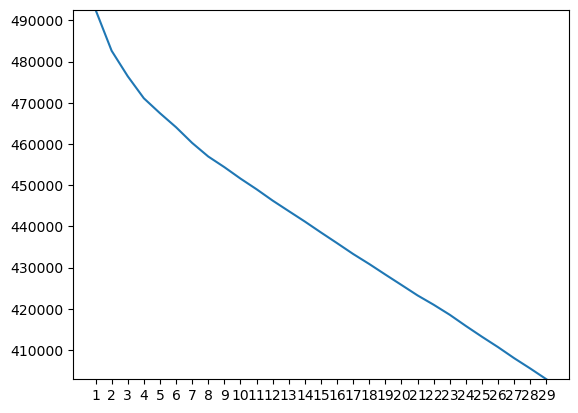

In [1802]:
import matplotlib.pyplot as plt

mean_final_losses = {n:np.mean([l[-1] for l in losses.values()]) for n,losses in losses_kfold.items()}
plt.ylim((min(mean_final_losses.values()),max(mean_final_losses.values())))
plt.plot(range(1,len(mean_final_losses)+1), mean_final_losses.values())
plt.xticks(range(1, len(mean_final_losses)+1))
plt.show()

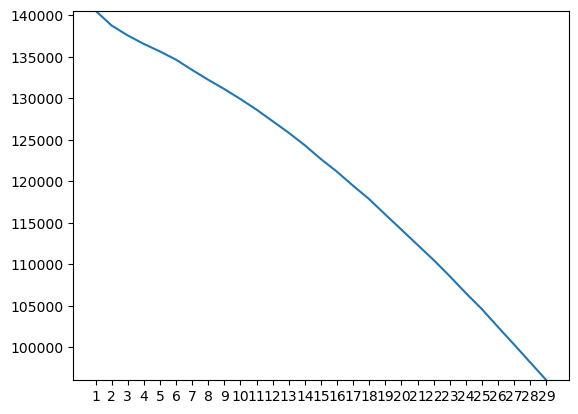

In [1803]:
import matplotlib.pyplot as plt

mean_final_test_losses = {n:np.mean([l[-1] for l in losses.values()]) for n,losses in test_losses_kfold.items()}
plt.ylim((min(mean_final_test_losses.values()),max(mean_final_test_losses.values())))
plt.plot(range(1,len(mean_final_test_losses)+1), mean_final_test_losses.values())
plt.xticks(range(1, len(mean_final_test_losses)+1))
plt.show()

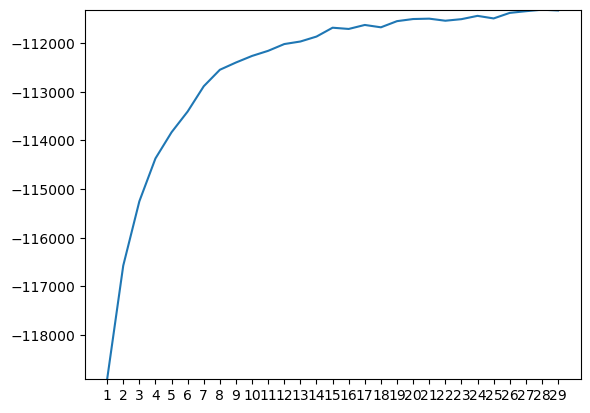

In [1804]:
def kfold_mean_likelihood(likelihoods):
    return np.mean([l.sum() for l in likelihoods])

mean_test_likelihoods = {n: kfold_mean_likelihood(likelihoods) for n,likelihoods in test_likelihoods_kfold.items()}
plt.ylim((min(mean_test_likelihoods.values()),max(mean_test_likelihoods.values())))
plt.plot(range(1,len(mean_test_likelihoods)+1), mean_test_likelihoods.values())
plt.xticks(range(1, len(mean_test_likelihoods)+1))
plt.show()

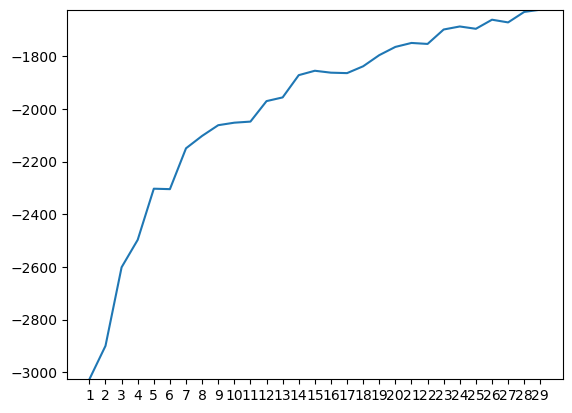

In [1805]:
mean_test_likelihoods_inference = {n: kfold_mean_likelihood(likelihoods) for n,likelihoods in test_likelihoods_inference_kfold.items()}
plt.ylim((min(mean_test_likelihoods_inference.values()),max(mean_test_likelihoods_inference.values())))
plt.plot(range(1,len(mean_test_likelihoods_inference)+1), mean_test_likelihoods_inference.values())
plt.xticks(range(1, len(mean_test_likelihoods_inference)+1))
plt.show()

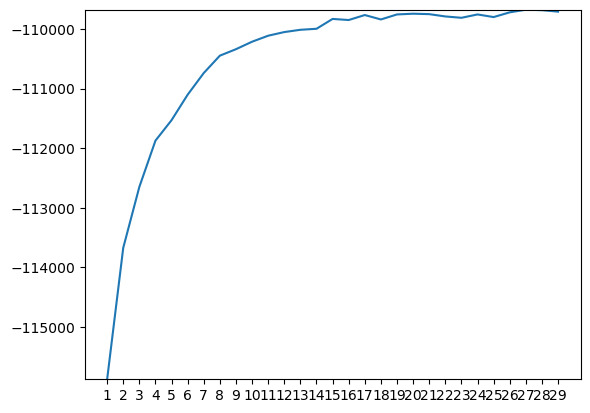

In [1806]:
mean_test_likelihoods_syntax = {n: kfold_mean_likelihood(likelihoods) for n,likelihoods in test_likelihoods_syntax_kfold.items()}
plt.ylim((min(mean_test_likelihoods_syntax.values()),max(mean_test_likelihoods_syntax.values())))
plt.plot(range(1,len(mean_test_likelihoods_syntax)+1), mean_test_likelihoods_syntax.values())
plt.xticks(range(1, len(mean_test_likelihoods_syntax)+1))
plt.show()

We use a bootstrapped likelihood ratio test with bonferroni corrections to choose the optimal number of clusters. We choose the minimum number of clusters such that no model with a greater number of clusters performs reliably better on both the inference and syntactic judgments.

In [1807]:
def kfold_mean_likelihood_per_item(likelihoods):
    return np.array(likelihoods).mean(0)

kfold_mean_likelihood_per_item(test_likelihoods_inference_kfold[2]).shape

(1007,)

In [1808]:
curr_n_components = min(test_likelihoods_kfold)
curr_best = True
n_tests = 0

while True:
    for n_components in range(curr_n_components+1, max(test_likelihoods_kfold)+1):
        # loss_inf = -kfold_mean_likelihood_per_item(test_likelihoods_inference_kfold[n_components])
        # loss_inf_curr = -kfold_mean_likelihood_per_item(test_likelihoods_inference_kfold[curr_n_components])
        # loss_syn = -kfold_mean_likelihood_per_item(test_likelihoods_syntax_kfold[n_components])
        # loss_syn_curr = -kfold_mean_likelihood_per_item(test_likelihoods_syntax_kfold[curr_n_components])
        loss = -kfold_mean_likelihood_per_item(test_likelihoods_kfold[n_components])
        loss_curr = -kfold_mean_likelihood_per_item(test_likelihoods_kfold[curr_n_components])

        # lr_inf = loss_inf - loss_inf_curr
        # lr_syn = loss_syn - loss_syn_curr
        lr = loss - loss_curr

        alpha = 0.025/(n_tests+1)
        
        # ci_inf = np.quantile([np.sum(np.random.choice(lr_inf.flatten(), 
        #                                               size=len(lr_inf.flatten()),
        #                                               replace=True))
        #                                for _ in range(999)], [alpha, 0.5, 1.-alpha])
        # ci_syn = np.quantile([np.sum(np.random.choice(lr_syn.flatten(), 
        #                                               size=len(lr_syn.flatten()),
        #                                               replace=True))
        #                                for _ in range(999)], [alpha, 0.5, 1.-alpha])
        ci = np.quantile([np.sum(np.random.choice(lr.flatten(), 
                                                      size=len(lr.flatten()),
                                                      replace=True))
                                       for _ in range(999)], [alpha, 0.5, 1.-alpha])

        n_tests += 1

        # if ci_inf[2] < 0 and ci_syn[2] < 0:
        #     ci_inf = np.round(ci_inf, 3)
        #     ci_syn = np.round(ci_syn, 3)
        #     print(f'Model with {n_components} components outperforms '
        #           f'model with {curr_n_components} components')
        #     print(f'Difference in inference log-likelihood: {ci_inf[1]}, 95%CI=[{ci_inf[0]}, {ci_inf[2]}], alpha={np.round(alpha, 5)}')
        #     print(f'Difference in syntax log-likelihood: {ci_syn[1]}, 95%CI=[{ci_syn[0]}, {ci_syn[2]}], alpha={np.round(alpha, 5)}')
        #     print()
        #     curr_n_components += 1
        #     break
        if ci[2] < 0:
            ci = np.round(ci, 3)
            print(f'Model with {n_components} components outperforms '
                  f'model with {curr_n_components} components')
            print(f'Difference in log-likelihood: {ci[1]}, 95%CI=[{ci[0]}, {ci[2]}], alpha={np.round(alpha, 5)}')
            print()
            curr_n_components += 1
            break

    else:
        print()
        print(f'The model with {curr_n_components} components is the optimal model.')
        
        best_n_components = curr_n_components
        break      

Model with 3 components outperforms model with 2 components
Difference in log-likelihood: -2333.77, 95%CI=[-2512.047, -2154.598], alpha=0.025

Model with 4 components outperforms model with 3 components
Difference in log-likelihood: -1317.971, 95%CI=[-1458.465, -1173.106], alpha=0.0125

Model with 5 components outperforms model with 4 components
Difference in log-likelihood: -882.232, 95%CI=[-1008.279, -743.266], alpha=0.00833

Model with 6 components outperforms model with 5 components
Difference in log-likelihood: -536.519, 95%CI=[-682.805, -394.713], alpha=0.00625

Model with 7 components outperforms model with 6 components
Difference in log-likelihood: -427.128, 95%CI=[-558.956, -293.152], alpha=0.005

Model with 8 components outperforms model with 7 components
Difference in log-likelihood: -518.948, 95%CI=[-637.202, -412.498], alpha=0.00417

Model with 9 components outperforms model with 8 components
Difference in log-likelihood: -342.781, 95%CI=[-455.682, -228.188], alpha=0.00357

We now fit the full model with the optimal number of clusters.

In [1809]:
models = {}
losses = {}
parameters = {}

# CHECKPOINT_DIR = 'ckpt-sem-syn'

# for n_components in range(22, 23):
for n_components in range(best_n_components, best_n_components+1):
    print()
    pickle_name = f'{CHECKPOINT_DIR}/{n_components}.pickle'
    losses_pickle_name = f'{CHECKPOINT_DIR}/{n_components}_losses.pickle'
    print()
    
    if USE_CHECKPOINTS and os.path.isfile(pickle_name):
        print(f'Loading model with {n_components} components from checkpoint...')
        with open(pickle_name, 'rb') as f:
            models[n_components] = pickle.load(f)
    if USE_CHECKPOINTS and os.path.isfile(losses_pickle_name):
        with open(losses_pickle_name, 'rb') as f:
            losses[n_components] = pickle.load(f)
    
    else:
        print(f'Fitting model with {n_components} components...')
        models[n_components] = MultiviewMixedEffectsMixture(data, n_components, num_kmeans_trials=1, seed=403921)
        # models[n_components] = MultiviewMixedEffectsMixture(data, n_components, num_kmeans_trials=1, seed=403921, component_dispersion=.9375)
        _, _, losses[n_components] = models[n_components].fit(data, lr=0.02, tolerance=1e-7, n_epochs=10000, batch_size=0.05, patience=1000, verbosity=100)
        
        if USE_CHECKPOINTS:
            with open(pickle_name, 'wb') as f:
                pickle.dump(models[n_components], f)
            with open(losses_pickle_name, 'wb') as f:
                pickle.dump(losses[n_components], f)
    
    
    parameters[n_components] = {'weights': models[n_components].param('weights').data.numpy(),
                                'membership_probs': pd.DataFrame(models[n_components].membership_probabilities(data).data.numpy(), 
                                                        index=models[n_components]._verb),
                                'belief_desire_locs': pd.DataFrame(models[n_components].get_model('belief_desire')._locs().data.numpy(),
                                                                   columns=mc.item.astype('category').cat.categories).T,
                                'veridicality_locs': pd.DataFrame(models[n_components].get_model('veridicality')._locs().data.numpy(),
                                                                  columns=mv.item.astype('category').cat.categories).T,
                                'negraising_locs': pd.DataFrame(models[n_components].get_model('negraising')._locs().data.numpy(),
                                                                  columns=mn.item.astype('category').cat.categories).T,
                                'acceptability_locs': pd.DataFrame(models[n_components].get_model('acceptability')._locs().data.numpy(),
                                                                  columns=ma.item.astype('category').cat.categories).T,
                                'belief_desire_theta_1': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[0].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'belief_desire_theta_0': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[1].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'belief_desire_theta_prior': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[2].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'veridicality_jumps': models[n_components].get_model('veridicality')._jumps().data.numpy(),
                                'negraising_theta_1': pd.DataFrame(models[n_components].get_model('negraising')._theta()[0].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'negraising_theta_0': pd.DataFrame(models[n_components].get_model('negraising')._theta()[1].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'negraising_theta_prior': pd.DataFrame(models[n_components].get_model('negraising')._theta()[2].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'acceptability_jumps': models[n_components].get_model('acceptability')._jumps().data.numpy(),
                               }
    
    print()
    print('=====================================================================================')



Fitting model with 25 components...
Computing KMeans initialization with minimum squared error; current minimum: inf
epoch 0: 1204611.5

epoch 100: 531283.25

epoch 200: 526586.8125

epoch 300: 525123.125

epoch 400: 524516.5625

epoch 500: 524113.03125

epoch 600: 523876.84375

epoch 700: 523738.1875

epoch 800: 523614.15625

epoch 900: 523453.15625

epoch 1000: 523478.59375

epoch 1100: 523368.4375

epoch 1138: 523415.25



In [1810]:
# best_n_components = 22
best_model = parameters[best_n_components]

In [1811]:
# testprobs = parameters[best_n_components]['membership_probs'].round(decimals=3)
# testprobs.head(50)
# # testprobs.hist()
# for ntest in range(best_n_components):
#     # testslice = testprobs[(testprobs[ntest] > 0.3) & (testprobs[ntest] < 0.7)]
#     testslice = testprobs[(testprobs[ntest] > 0.9)]
#     if not testslice.empty:
#         print(ntest, testslice)
# # testprobs.loc['afford']

In [1812]:
# import matplotlib.pyplot as plt

# if losses and all([i in losses for i in [2,4,16,20]]):
#     test1 = losses[2][:5000]
#     test2 = losses[4][:5000]
#     test3 = losses[16][:5000]
#     test4 = losses[20][:5000]
#     ylim_min = min([l for t in [test1, test2, test3, test4] for l in t])
#     ylim_max = max([l for t in [test1, test2, test3, test4] for l in t])
#     plt.ylim((ylim_min, ylim_max))
#     plt.plot(test1, label='2 components')
#     plt.plot(test2, label='4 components')
#     plt.plot(test3, label='16 components')
#     plt.plot(test4, label='20 components')
#     plt.legend()

In [1854]:
# def model_likelihood(model):
#     return np.sum(model.likelihood_per_item(data).detach().numpy())

# final_likelihoods = {k: model_likelihood(m) for k,m in models.items()}
# plt.ylim((min(final_likelihoods.values()),max(final_likelihoods.values())))
# plt.plot(range(1,len(final_likelihoods)+1), final_likelihoods.values())
# plt.xticks(range(1, len(final_likelihoods)+1))
# plt.show()

In [1814]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.model.parameters() if p.requires_grad)

# count_parameters(models[2])

In [1815]:
# def AIC(name, model):
#     k = count_parameters(model)
#     lp = -final_likelihoods[name]
#     return 2*k - 2*lp

# AICs = {name:AIC(name,model) for name,model in models.items()}
# plt.ylim((min(AICs.values()),max(AICs.values())))
# plt.plot(range(1,len(AICs)+1), AICs.values())
# plt.xticks(range(1, len(AICs)+1))
# plt.show()

In [1816]:
# def BIC(name, model, data):
#     k = count_parameters(model)
#     n = sum([len(d.dataframe) for d in data])
#     lp = -final_likelihoods[name]
#     return k*np.log(n) - 2*lp

# BICs = {name:BIC(name,model,data) for name,model in models.items()}
# plt.ylim((min(BICs.values()),max(BICs.values())))
# plt.plot(range(1,len(BICs)+1), BICs.values())
# plt.xticks(range(1, len(BICs)+1))
# plt.show()

To investigate the verb-frame pairs that fall into each cluster, we look at pairs that have probability 1 for that cluster. 

In [1817]:
for i in range(best_n_components):
    print(f'Verbs with highest weight for component {i}')
    print(best_model['membership_probs'][best_model['membership_probs'][i]>=0.3].head(50).index)
    print()
    
if os.path.exists('loadings_dumped'):
    best_model['membership_probs'].to_csv('loadings_dumped/membership_probs.csv')
best_model['membership_probs'].round(decimals=3)

Verbs with highest weight for component 0
Index(['affront', 'bear', 'bless', 'chide', 'cloud', 'embitter', 'faze',
       'gladden', 'jar', 'malign', 'set', 'sorrow'],
      dtype='object')

Verbs with highest weight for component 1
Index(['accept', 'comprehend', 'detect', 'discover', 'figure_out', 'find',
       'find_out', 'hear', 'identify', 'know', 'notice', 'observe', 'overhear',
       'realize', 'recognize', 'remember', 'see', 'understand'],
      dtype='object')

Verbs with highest weight for component 2
Index(['abhor', 'admonish', 'belittle', 'blast', 'constrain', 'demystify',
       'denounce', 'detest', 'disallow', 'dislike', 'disparage', 'face',
       'forbid', 'loathe', 'mistrust', 'pardon', 'prohibit', 'repress',
       'reproach'],
      dtype='object')

Verbs with highest weight for component 3
Index(['articulate', 'babble', 'blog', 'boast', 'brag', 'clarify', 'comment',
       'communicate', 'confess', 'demonstrate', 'divulge', 'elaborate',
       'embellish', 'exclai

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
abhor,0.006,0.000,0.302,0.000,0.141,0.037,0.000,0.000,0.056,0.095,...,0.000,0.000,0.000,0.031,0.000,0.000,0.000,0.151,0.034,0.000
absolve,0.000,0.000,0.202,0.000,0.000,0.082,0.000,0.216,0.000,0.000,...,0.000,0.000,0.024,0.000,0.094,0.077,0.016,0.000,0.026,0.000
accept,0.000,0.381,0.000,0.048,0.000,0.101,0.031,0.000,0.000,0.000,...,0.000,0.007,0.077,0.095,0.000,0.000,0.043,0.000,0.105,0.000
acclaim,0.132,0.014,0.028,0.037,0.000,0.010,0.000,0.075,0.000,0.012,...,0.000,0.000,0.289,0.000,0.082,0.054,0.000,0.000,0.009,0.036
accredit,0.077,0.000,0.000,0.000,0.000,0.000,0.000,0.053,0.000,0.000,...,0.000,0.000,0.177,0.000,0.000,0.000,0.060,0.032,0.000,0.147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
write,0.021,0.008,0.000,0.414,0.000,0.000,0.121,0.000,0.000,0.000,...,0.000,0.134,0.000,0.245,0.000,0.000,0.003,0.000,0.000,0.000
yawn,0.000,0.018,0.000,0.000,0.000,0.151,0.000,0.010,0.000,0.000,...,0.214,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.014
yearn,0.011,0.000,0.000,0.000,0.000,0.522,0.099,0.000,0.000,0.042,...,0.002,0.000,0.000,0.000,0.000,0.068,0.011,0.014,0.122,0.000
yell,0.000,0.000,0.000,0.389,0.000,0.018,0.299,0.000,0.000,0.031,...,0.061,0.064,0.000,0.058,0.010,0.000,0.000,0.000,0.042,0.000


We label these clusters on the basis of the verb-frame pairs that fall into them and the inference patterns associated with them.

In [1818]:
# TODO vvvvvvvvv

# cluster_labels = {0: '',
#                   1: '',
#                   2: '',
#                   3: '',
#                   4: '',
#                   5: '',
#                   6: '',
#                   7: '',
#                   8: '',
#                   9: '',
#                   10: '',
#                   11: '',
#                   12: '',
#                   13: '',
#                   14: '',
#                   15: '',
#                   16: '',
#                   17: '',
#                   18: '',
#                   19: '',
# }
# cluster_labels_inv = { v:k for k,v in cluster_labels.items() }
# cluster_order = [cluster_labels[i] for i in [3, 13, 12, 4, 5, 9, 10, 15, 11, 14, 2, 16, 1, 7, 0, 8, 6]]

cluster_labels = {i: str(i) for i in range(best_n_components)}
cluster_order = [cluster_labels[i] for i in list(cluster_labels.keys())]

cluster_order

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24']

Figures 4-6 of the paper plot the means for each cluster relative to each view.

In [1819]:
best_model['belief_desire_value'] = (1 * best_model['belief_desire_theta_1']
                                     + 0 * best_model['belief_desire_theta_0']
                                     + best_model['belief_desire_locs'] * best_model['belief_desire_theta_prior'])

if os.path.exists('loadings_dumped'):
    best_model['belief_desire_value'].to_csv('loadings_dumped/belief_desire.csv')
best_model['belief_desire_value']

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
negative-object-na-believe-NP V NP that S,1.203852e-07,9.999999e-01,3.521284e-01,5.114229e-01,5.018746e-01,1.000000e+00,5.156066e-01,1.530288e-20,9.999995e-01,3.483594e-04,...,1.000000e+00,4.723500e-01,6.912244e-21,4.940221e-01,4.956115e-01,9.608570e-06,4.884833e-01,4.900157e-01,1.000000e+00,4.875439e-01
negative-object-na-believe-NP V NP that S[+future],4.475707e-16,1.000000e+00,6.265430e-18,1.386170e-34,3.340585e-18,2.138584e-18,2.715411e-15,6.133491e-20,4.960816e-01,8.031405e-13,...,3.767165e-07,1.091425e-09,2.307115e-18,4.904622e-01,1.539780e-09,2.866543e-09,4.680111e-01,4.916508e-01,4.981231e-01,4.827145e-01
negative-object-na-believe-NP V NP that S[-tense],3.443536e-21,6.075349e-21,9.973420e-02,9.372302e-22,4.139380e-03,5.788348e-14,5.374957e-21,8.830138e-21,4.033237e-01,1.139859e-08,...,1.196845e-05,5.000312e-01,1.090488e-20,3.413556e-21,2.136688e-03,3.982659e-21,5.834342e-22,1.400858e-20,3.960688e-16,1.875813e-21
negative-object-na-believe-NP V to NP that S,1.727431e-38,4.752842e-01,8.808259e-01,4.890521e-01,5.047414e-01,4.768967e-01,4.794636e-01,1.371132e-37,1.000000e+00,7.021146e-01,...,5.215057e-01,5.076711e-01,4.889099e-01,4.598159e-01,4.995688e-01,6.673647e-01,2.275493e-33,4.998871e-01,4.939558e-01,7.011234e-37
negative-object-na-believe-NP V to NP that S[+future],1.125075e-37,1.459975e-25,9.999717e-01,2.354013e-01,3.940844e-15,7.598846e-38,4.795414e-01,1.602675e-37,9.999998e-01,8.955001e-01,...,5.085270e-01,2.138491e-05,4.969145e-01,1.217588e-01,5.002997e-01,7.554000e-01,4.240000e-38,5.017487e-01,7.305201e-33,1.319759e-34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
positive-subject-subject-want-NP V VPing,1.000000e+00,1.000000e+00,2.362536e-01,1.000000e+00,4.828687e-01,1.000000e+00,1.000000e+00,1.000000e+00,4.375034e-01,4.205443e-01,...,5.084885e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.070265e-01,1.000000e+00,1.294915e-08,1.000000e+00,1.000000e+00
positive-subject-subject-want-NP V to NP to VP[+eventive],9.749572e-01,1.112772e-03,3.543779e-02,1.000000e+00,9.999832e-01,1.315943e-03,1.819780e-03,1.689520e-02,1.492756e-07,2.514643e-22,...,9.995996e-01,1.306273e-02,9.116490e-01,4.929574e-03,9.991568e-01,5.867534e-18,9.662066e-01,9.999995e-01,4.140129e-03,9.778080e-01
positive-subject-subject-want-NP V to NP to VP[-eventive],3.079637e-01,6.677278e-01,3.115645e-01,6.677504e-01,6.672117e-01,3.444549e-01,6.675937e-01,6.677367e-01,3.037379e-01,6.677203e-01,...,2.946037e-01,6.671116e-01,6.679516e-01,6.674808e-01,4.778083e-01,6.677042e-01,6.550091e-01,3.152640e-01,6.678014e-01,6.676690e-01
positive-subject-subject-want-NP V to VP[+eventive],1.000000e+00,1.000000e+00,2.902491e-08,1.000000e+00,5.330590e-09,1.000000e+00,1.000000e+00,1.000000e+00,5.629548e-08,2.612902e-08,...,1.879255e-07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999863e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [1820]:
best_belief_desire_locs = best_model['belief_desire_value']

factors = np.array([np.array(x) for x 
                    in best_belief_desire_locs.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_belief_desire_locs[['polarity', 'target', 'control', 'consequent_verb', 'frame']] = factors
best_belief_desire_locs['frame'] = best_belief_desire_locs.frame.str.replace('0', '-')
best_belief_desire_locs['tense'] = 'past'

# best_belief_desire_locs = best_belief_desire_locs.pivot_table(values=range(0, best_n_components), index=['polarity', 'target', 'control', 'consequent_verb']).reset_index()

def form_belief_desire_antecedent(row, frame=False, polarity=False):
    positive = not polarity or row.polarity == 'positive'
    if frame:
        antecedent = row.frame.replace(' V ', ' __ ') if positive else row.frame.replace(' V ', ' not __ ')
        antecedent = antecedent.replace('NP', 'A', 1)
        antecedent = antecedent.replace('NP', 'B')
    else:
        return "____"
        # if row.control == 'na':
        #     antecedent = "A __ ((to) B) that S" if positive else "A not __ ((to) B) that S"
        # else:
        #     antecedent = "A __ ((to) B) to VP" if positive else "A not __ ((to) B) to VP"
    return antecedent

best_belief_desire_locs['template'] = best_belief_desire_locs.apply(form_belief_desire_antecedent, axis=1) +\
                                      ' ~> ' +\
                                      best_belief_desire_locs.target.map({'subject': 'A',
                                                                          'object': 'B'}) + ' ' +\
                                      best_belief_desire_locs.consequent_verb + 's ' +\
                                      best_belief_desire_locs.control.map({'subject': 'A ',
                                                                          'object': 'B ',
                                                                          'na':''}) +\
                                      best_belief_desire_locs.control.map({'subject': 'VP', 'object': 'VP',
                                                                           'na': 'S'})

# best_belief_desire_locs_melt = pd.melt(best_belief_desire_locs.drop(columns=['target', 'control', 'consequent_verb', 'frame']), 
#                                        id_vars=['polarity', 'template'])
# best_belief_desire_locs_melt = pd.melt(best_belief_desire_locs.drop(columns=['target', 'control', 'consequent_verb']), 
#                                        id_vars=['polarity', 'template'])
best_belief_desire_locs_melt = pd.melt(best_belief_desire_locs.drop(columns=['target', 'control', 'consequent_verb']), 
                                       id_vars=['polarity', 'template', 'frame', 'tense'])

# best_belief_desire_locs_melt = best_belief_desire_locs_melt.drop(columns='polarity')

best_belief_desire_locs_melt['label'] = best_belief_desire_locs_melt.variable.map(cluster_labels)
best_belief_desire_locs_melt['inferencetype'] = best_belief_desire_locs_melt.template.map(lambda x: 'doxastic' if 'believe' in x else 'bouletic' if 'want' in x else 'intention')

best_belief_desire_locs_melt

,polarity,template,frame,tense,variable,value,label,inferencetype
0,negative,____ ~> B believes S,NP V NP that S,past,0,1.203852e-07,0,doxastic
1,negative,____ ~> B believes S,NP V NP that S[+future],past,0,4.475707e-16,0,doxastic
2,negative,____ ~> B believes S,NP V NP that S[-tense],past,0,3.443536e-21,0,doxastic
3,negative,____ ~> B believes S,NP V to NP that S,past,0,1.727431e-38,0,doxastic
4,negative,____ ~> B believes S,NP V to NP that S[+future],past,0,1.125075e-37,0,doxastic
...,...,...,...,...,...,...,...,...
4795,positive,____ ~> A wants A VP,NP V VPing,past,24,1.000000e+00,24,bouletic
4796,positive,____ ~> A wants A VP,NP V to NP to VP[+eventive],past,24,9.778080e-01,24,bouletic
4797,positive,____ ~> A wants A VP,NP V to NP to VP[-eventive],past,24,6.676690e-01,24,bouletic
4798,positive,____ ~> A wants A VP,NP V to VP[+eventive],past,24,1.000000e+00,24,bouletic


In [1821]:
best_model['negraising_value'] = (1 * best_model['negraising_theta_1']
                                  + 0 * best_model['negraising_theta_0']
                                  + best_model['negraising_locs'] * best_model['negraising_theta_prior'])

if os.path.exists('loadings_dumped'):
    best_model['negraising_value'].to_csv('loadings_dumped/negraising.csv')
best_model['negraising_value']

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
first-past-NP V that S,8.666409e-08,1.314246e-08,1.749823e-08,4.593288e-07,2.046077e-16,3.253335e-08,1.227287e-05,5.587899e-02,7.118336e-08,1.112262e-08,...,2.290535e-09,2.217183e-04,1.210678e-12,3.797944e-04,2.629290e-09,2.590976e-13,1.590612e-05,1.203378e-17,2.809077e-05,3.914351e-05
first-past-NP V to VP[+eventive],7.583328e-01,8.674124e-01,2.816273e-10,6.783091e-10,3.840842e-07,6.696925e-01,9.693664e-01,6.699154e-27,6.327233e-11,1.063549e-15,...,5.732947e-11,5.089077e-11,9.925479e-01,8.873445e-01,2.176599e-15,7.619740e-17,1.146551e-06,3.973204e-11,9.957165e-01,6.214079e-01
first-past-NP V to VP[-eventive],9.999993e-01,9.999927e-01,4.974435e-10,4.682397e-01,9.072862e-11,1.584808e-10,1.076804e-04,5.127502e-01,6.139105e-08,1.396301e-01,...,7.634483e-11,5.009613e-01,3.035548e-04,1.845015e-02,7.865932e-15,3.552775e-12,3.099573e-14,2.425005e-11,6.818017e-02,2.590763e-11
first-past-NP be V that S,3.690169e-09,4.323084e-09,1.418405e-03,5.114990e-01,9.106965e-12,1.795347e-01,5.092819e-01,1.148480e-14,7.086845e-05,4.332869e-08,...,1.485471e-02,6.123782e-13,3.343383e-01,4.859255e-01,2.382804e-14,3.419257e-05,7.587483e-13,1.580818e-08,1.794878e-08,1.959882e-11
first-past-NP be V to VP[+eventive],1.786571e-20,9.929911e-01,6.163440e-28,3.941067e-01,3.248762e-11,1.820447e-03,4.550362e-02,3.971325e-01,8.543358e-11,1.352750e-04,...,4.006043e-05,1.579754e-14,2.583293e-01,1.264046e-01,8.959795e-23,1.157389e-02,2.722095e-19,1.031982e-15,1.115101e-03,3.562911e-01
first-past-NP be V to VP[-eventive],5.180380e-01,9.998962e-01,4.719216e-01,8.079063e-01,3.786690e-03,6.000824e-04,9.989918e-01,5.024022e-01,4.912229e-01,5.265605e-01,...,4.700375e-01,4.796183e-01,9.919719e-01,4.458634e-01,4.910121e-01,5.110513e-01,1.948440e-10,5.505158e-03,5.821590e-01,4.981078e-01
first-present-NP V that S,2.326558e-04,9.999999e-01,3.253480e-04,3.449425e-06,1.097064e-05,5.595687e-06,9.999999e-01,8.445647e-01,4.380380e-05,6.422795e-05,...,4.783552e-05,1.434890e-06,9.999995e-01,9.459712e-06,1.696305e-11,1.309064e-05,1.425425e-05,2.530931e-06,9.999999e-01,3.149917e-02
first-present-NP V to VP[+eventive],9.999726e-01,5.435590e-01,8.997321e-14,6.499316e-01,6.979333e-02,9.999868e-01,9.999266e-01,9.978125e-01,7.776518e-09,2.809531e-09,...,3.209964e-15,4.132459e-02,5.469227e-01,9.998953e-01,9.999695e-01,5.455912e-02,9.994540e-01,6.247053e-01,1.000000e+00,9.999951e-01
first-present-NP V to VP[-eventive],9.994574e-01,9.942751e-01,4.212730e-09,3.019951e-01,3.631938e-03,9.988785e-01,5.105356e-03,1.726264e-02,2.312213e-19,3.344716e-06,...,3.876537e-15,5.124435e-01,9.999979e-01,5.301520e-01,9.903203e-01,6.151634e-05,6.487938e-09,1.127817e-22,9.981306e-01,9.998079e-01
first-present-NP be V that S,1.122498e-10,4.756252e-01,7.576343e-09,6.461996e-04,3.163279e-09,3.282203e-04,1.181453e-13,2.472072e-09,5.019085e-01,7.557205e-09,...,2.500572e-08,1.573764e-01,1.658701e-08,1.742839e-03,3.083886e-11,8.414036e-09,3.114039e-09,4.546816e-11,5.911489e-18,1.594561e-07


In [1822]:
best_negraising_locs = best_model['negraising_value']

factors = np.array([np.array(x) for x 
                    in best_negraising_locs.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_negraising_locs[['person', 'tense', 'frame']] = factors
best_negraising_locs['frame'] = best_negraising_locs.frame.str.replace('0', '-')

# best_negraising_locs = best_negraising_locs.pivot_table(values=range(0, best_n_components), index=['person', 'tense']).reset_index()

def form_negraising_antecedent(row, frame=False, tense=False):
    if frame:
        antecedent = row.frame.replace(' V ', ' not __[past] ') if row.tense == 'past' else row.frame.replace(' V ', ' not __[pres] ')
    else:
        antecedent = 'NP not __[past] NP' if row.tense == 'past' else 'NP not __[pres] NP'
    antecedent = antecedent.replace('NP', 'A[1s]', 1) if row.person == 'first' else antecedent.replace('NP', 'A[3s]', 1)
    antecedent = antecedent.replace('NP', 'B')
    if not tense:
        antecedent = antecedent.replace('[pres]', '').replace('[past]', '')
    return antecedent

best_negraising_locs['template'] = best_negraising_locs.apply(form_negraising_antecedent, axis=1) +\
                                   '~> ' +\
                                   best_negraising_locs.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' ' +\
                                   best_negraising_locs.tense.map({'past': '__', 'present': '__'}) + ' ' +\
                                   'not S'

# best_negraising_locs_melt = pd.melt(best_negraising_locs.drop(columns=['person', 'tense', 'frame']), 
#                                        id_vars='template')
# best_negraising_locs_melt = pd.melt(best_negraising_locs.drop(columns=['person', 'tense']), 
#                                        id_vars='template')
best_negraising_locs_melt = pd.melt(best_negraising_locs.drop(columns=['person']), 
                                       id_vars=['template', 'frame', 'tense'])

best_negraising_locs_melt['label'] = best_negraising_locs_melt.variable.map(cluster_labels)

best_negraising_locs_melt['inferencetype'] = 'negraising'

best_negraising_locs_melt

,template,frame,tense,variable,value,label,inferencetype
0,A[1s] not __ B~> A[1s] __ not S,NP V that S,past,0,8.666409e-08,0,negraising
1,A[1s] not __ B~> A[1s] __ not S,NP V to VP[+eventive],past,0,7.583328e-01,0,negraising
2,A[1s] not __ B~> A[1s] __ not S,NP V to VP[-eventive],past,0,9.999993e-01,0,negraising
3,A[1s] not __ B~> A[1s] __ not S,NP be V that S,past,0,3.690169e-09,0,negraising
4,A[1s] not __ B~> A[1s] __ not S,NP be V to VP[+eventive],past,0,1.786571e-20,0,negraising
...,...,...,...,...,...,...,...
595,A[3s] not __ B~> A[3s] __ not S,NP V to VP[+eventive],present,24,1.000000e+00,24,negraising
596,A[3s] not __ B~> A[3s] __ not S,NP V to VP[-eventive],present,24,8.031680e-01,24,negraising
597,A[3s] not __ B~> A[3s] __ not S,NP be V that S,present,24,3.809858e-14,24,negraising
598,A[3s] not __ B~> A[3s] __ not S,NP be V to VP[+eventive],present,24,6.489601e-11,24,negraising


In [1823]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

In [1824]:
veridicality_jumps = best_model['veridicality_jumps']
veridicality_cuts = np.exp(veridicality_jumps).cumsum(axis=0)
veridicality_cuts = veridicality_cuts - np.mean(veridicality_cuts)

veridicality_locs = best_model['veridicality_locs'].to_numpy()
veridicality_locs = np.concatenate(veridicality_cuts.shape[-1]*[veridicality_locs[:,:,None]], axis=-1)

veridicality_cdf = sigmoid(veridicality_cuts - veridicality_locs)
veridicality_cdf_pad_shape = list(veridicality_cdf.shape[:-1])+[1]
veridicality_cdf_high = np.concatenate([veridicality_cdf, np.ones(veridicality_cdf_pad_shape)], axis=-1)
veridicality_cdf_low = np.concatenate([np.zeros(veridicality_cdf_pad_shape), veridicality_cdf], axis=-1)

veridicality_pmf = veridicality_cdf_high - veridicality_cdf_low

veridicality_levels = np.expand_dims(np.linspace(0., 1., veridicality_pmf.shape[-1]), axis=(0,1))

veridicality_value = best_model['veridicality_locs'].copy()
veridicality_value[list(range(best_n_components))] = np.sum(veridicality_pmf*veridicality_levels, axis=2)
best_model['veridicality_value'] = veridicality_value

if os.path.exists('loadings_dumped'):
    best_model['veridicality_value'].to_csv('loadings_dumped/veridicality.csv')
best_model['veridicality_value']

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
negative-NP V NP to VP[+eventive],0.337051,0.166958,0.480052,0.275602,0.465354,0.460462,0.451428,0.247977,0.450999,0.967077,...,0.196837,0.281353,0.382806,0.405938,0.307117,0.985255,0.399543,0.300547,0.467971,0.267841
negative-NP V NP to VP[-eventive],0.426950,0.534022,0.485424,0.420717,0.499117,0.484860,0.455764,0.440453,0.558628,0.993118,...,0.402028,0.390543,0.398775,0.368493,0.477960,0.469434,0.473162,0.443791,0.413657,0.186578
negative-NP V for NP to VP,0.985277,0.988644,0.472535,0.383942,0.511316,0.449315,0.460163,0.388810,0.472170,0.490932,...,0.446406,0.483245,0.235954,0.415542,0.493618,0.424937,0.403031,0.394543,0.473571,0.195835
negative-NP V that S,0.400155,0.991462,0.513407,0.446109,0.840468,0.515013,0.389719,0.251272,0.498562,0.938646,...,0.534554,0.521484,0.181458,0.330020,0.980454,0.985018,0.472589,0.474811,0.430859,0.341793
negative-NP V to VP[+eventive],0.975738,0.077586,0.481698,0.393848,0.955346,0.302507,0.334979,0.267276,0.477131,0.983446,...,0.470398,0.384813,0.009463,0.413221,0.290284,0.493940,0.216233,0.453529,0.487555,0.246293
negative-NP V to VP[-eventive],0.523636,0.137819,0.476986,0.418173,0.332591,0.462759,0.369936,0.313990,0.493749,0.989898,...,0.406072,0.399435,0.005682,0.407877,0.289906,0.583782,0.390757,0.485629,0.340132,0.227689
negative-NP be V that S,0.681260,0.501030,0.729022,0.828082,0.958851,0.538771,0.365238,0.966183,0.479311,0.761284,...,0.676595,0.457391,0.442255,0.462675,0.755062,0.730222,0.631261,0.810467,0.549848,0.048733
negative-NP be V to VP[+eventive],0.394755,0.186471,0.481472,0.427153,0.480819,0.309534,0.460314,0.486186,0.469022,0.978332,...,0.432594,0.213956,0.236584,0.417108,0.217787,0.370652,0.454217,0.993596,0.442926,0.099041
negative-NP be V to VP[-eventive],0.308146,0.000963,0.487837,0.439688,0.975408,0.490860,0.447696,0.985270,0.501412,0.561490,...,0.418275,0.385134,0.261943,0.378097,0.445857,0.452181,0.393536,0.990998,0.450316,0.161181
positive-NP V NP to VP[+eventive],0.491157,0.484525,0.338159,0.482796,0.710163,0.459593,0.479646,0.989525,0.471775,0.005047,...,0.499360,0.489546,0.989003,0.482883,0.486178,0.504185,0.502766,0.985285,0.480655,0.997846


In [1825]:
best_veridicality_locs = best_model['veridicality_value']

factors = np.array([np.array(x) for x 
                    in best_veridicality_locs.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_veridicality_locs[['polarity', 'frame']] = factors
best_veridicality_locs['frame'] = best_veridicality_locs.frame.str.replace('0', '-')
best_veridicality_locs['tense'] = 'past'

# best_veridicality_locs = best_veridicality_locs.pivot_table(values=range(0, best_n_components), index=['polarity']).reset_index()

def form_veridicality_antecedent(row, frame=False, polarity=False):
    positive = not polarity or row.polarity == 'positive'
    if frame:
        antecedent = row.frame.replace(' V ', ' __ ') if positive else row.frame.replace(' V ', ' not __ ')
        antecedent = antecedent.replace('NP', 'A', 1)
        antecedent = antecedent.replace('NP', 'B')
    else:
        antecedent = 'A __ that/to S/VP' if positive else 'A not __ that/to S/VP'
    return antecedent

best_veridicality_locs['template'] = best_veridicality_locs.apply(form_veridicality_antecedent, axis=1) +\
                                     ' ~> S/VP'

# best_veridicality_locs_melt = pd.melt(best_veridicality_locs.drop(columns=['frame']), 
#                                        id_vars=['polarity', 'template'])
# best_veridicality_locs_melt = pd.melt(best_veridicality_locs, id_vars=['polarity', 'template'])
best_veridicality_locs_melt = pd.melt(best_veridicality_locs,
                                      id_vars=['polarity', 'template', 'frame', 'tense'])

# best_veridicality_locs_melt = best_veridicality_locs_melt.drop(columns='polarity')

best_veridicality_locs_melt['label'] = best_veridicality_locs_melt.variable.map(cluster_labels)
best_veridicality_locs_melt['inferencetype'] = 'veridicality'

best_veridicality_locs_melt

,polarity,template,frame,tense,variable,value,label,inferencetype
0,negative,A __ that/to S/VP ~> S/VP,NP V NP to VP[+eventive],past,0,0.337051,0,veridicality
1,negative,A __ that/to S/VP ~> S/VP,NP V NP to VP[-eventive],past,0,0.426950,0,veridicality
2,negative,A __ that/to S/VP ~> S/VP,NP V for NP to VP,past,0,0.985277,0,veridicality
3,negative,A __ that/to S/VP ~> S/VP,NP V that S,past,0,0.400155,0,veridicality
4,negative,A __ that/to S/VP ~> S/VP,NP V to VP[+eventive],past,0,0.975738,0,veridicality
...,...,...,...,...,...,...,...,...
445,positive,A __ that/to S/VP ~> S/VP,NP V to VP[+eventive],past,24,0.994680,24,veridicality
446,positive,A __ that/to S/VP ~> S/VP,NP V to VP[-eventive],past,24,0.988178,24,veridicality
447,positive,A __ that/to S/VP ~> S/VP,NP be V that S,past,24,0.098884,24,veridicality
448,positive,A __ that/to S/VP ~> S/VP,NP be V to VP[+eventive],past,24,0.997223,24,veridicality


In [1826]:
acceptability_jumps = best_model['acceptability_jumps']
acceptability_cuts = np.exp(acceptability_jumps).cumsum(axis=0)
acceptability_cuts = acceptability_cuts - np.mean(acceptability_cuts)

acceptability_locs = best_model['acceptability_locs'].to_numpy()
acceptability_locs = np.concatenate(acceptability_cuts.shape[-1]*[acceptability_locs[:,:,None]], axis=-1)

acceptability_cdf = sigmoid(acceptability_cuts - acceptability_locs)
acceptability_cdf_pad_shape = list(acceptability_cdf.shape[:-1])+[1]
acceptability_cdf_high = np.concatenate([acceptability_cdf, np.ones(acceptability_cdf_pad_shape)], axis=-1)
acceptability_cdf_low = np.concatenate([np.zeros(acceptability_cdf_pad_shape), acceptability_cdf], axis=-1)

acceptability_pmf = acceptability_cdf_high - acceptability_cdf_low

acceptability_levels = np.expand_dims(np.linspace(0., 1., acceptability_pmf.shape[-1]), axis=(0,1))

acceptability_value = best_model['acceptability_locs'].copy()
acceptability_value[list(range(best_n_components))] = np.sum(acceptability_pmf*acceptability_levels, axis=2)
best_model['acceptability_value'] = acceptability_value

if os.path.exists('loadings_dumped'):
    best_model['acceptability_value'].to_csv('loadings_dumped/acceptability.csv')
best_model['acceptability_value']

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
past-NP V,0.101364,0.991884,0.413490,0.999832,0.603933,0.999767,0.999967,0.287944,0.998015,0.819700,...,0.949246,0.997778,0.791143,0.834523,0.938834,0.998637,0.731057,0.209158,0.375215,0.878835
past-NP V NP,0.478653,0.999735,0.998155,0.999710,0.765190,0.284471,0.933865,0.409610,0.998446,0.998883,...,0.790731,0.248794,0.818954,0.999041,0.928098,0.367709,0.782209,0.184324,0.999526,0.883313
past-NP V NP VP,0.223305,0.201613,0.228404,0.342905,0.185854,0.169831,0.795583,0.273192,0.335568,0.277621,...,0.182743,0.998253,0.296691,0.628320,0.610665,0.242634,0.814692,0.216638,0.944494,0.999092
past-NP V NP VPing,0.199529,0.999749,0.846645,0.277896,0.210839,0.163355,0.258472,0.246037,0.897444,0.999319,...,0.147807,0.490188,0.561269,0.879957,0.945893,0.232149,0.997817,0.804209,0.828339,0.443364
past-NP V NP that S,0.176727,0.175184,0.258417,0.275476,0.316368,0.134761,0.237563,0.239937,0.656906,0.168020,...,0.165844,0.997301,0.286144,0.712675,0.281031,0.161270,0.852108,0.232514,0.226952,0.274188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
present-NP be V whether S[+future],0.458102,0.135968,0.002620,0.489576,0.821494,0.461307,0.529949,0.724738,0.786246,0.338337,...,0.279644,0.843885,0.368413,0.594540,0.355133,0.693874,0.810624,0.576420,0.240173,0.196312
present-NP be V whether to VP,0.667803,0.044159,0.339894,0.427139,0.863084,0.164243,0.002883,0.404941,0.565800,0.392995,...,0.452642,0.904623,0.282274,0.621229,0.371068,0.626775,0.725221,0.364199,0.382181,0.818471
present-NP be V whichNP S,0.484636,0.358555,0.753383,0.069845,0.039044,0.314619,0.352532,0.275551,0.711638,0.518560,...,0.439462,0.881841,0.532428,0.551135,0.184261,0.350981,0.572960,0.783839,0.499861,0.825244
present-NP be V whichNP to VP,0.030989,0.448240,0.196854,0.427996,0.530936,0.518685,0.247316,0.364128,0.472685,0.467182,...,0.456938,0.870152,0.388861,0.427045,0.451865,0.003858,0.775485,0.267584,0.748124,0.684862


In [1827]:
best_acceptability_locs = best_model['acceptability_value']

factors = np.array([np.array(x) for x 
                    in best_acceptability_locs.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_acceptability_locs[['tense', 'frame']] = factors
best_acceptability_locs['frame'] = best_acceptability_locs.frame.str.replace('0', '-')

def form_acceptability_antecedent(row):
    antecedent = row.frame.replace(' V ', ' __ ')
    antecedent = re.sub(r'V$', '__', antecedent)
    antecedent = antecedent.replace('__', '__[past]') if row.tense == 'past' else antecedent.replace('__', '__[pres]')
    # antecedent = antecedent.replace('NP', 'A', 1)
    # antecedent = antecedent.replace('NP', 'B')
    return antecedent

best_acceptability_locs['template'] = best_acceptability_locs.apply(form_acceptability_antecedent, axis=1)

best_acceptability_locs_melt = pd.melt(best_acceptability_locs,
                                       id_vars=['template', 'frame', 'tense'])

best_acceptability_locs_melt['label'] = best_acceptability_locs_melt.variable.map(cluster_labels)
best_acceptability_locs_melt['inferencetype'] = 'acceptability'

best_acceptability_locs_melt

,template,frame,tense,variable,value,label,inferencetype
0,NP __[past],NP V,past,0,0.101364,0,acceptability
1,NP __[past] NP,NP V NP,past,0,0.478653,0,acceptability
2,NP __[past] NP VP,NP V NP VP,past,0,0.223305,0,acceptability
3,NP __[past] NP VPing,NP V NP VPing,past,0,0.199529,0,acceptability
4,NP __[past] NP that S,NP V NP that S,past,0,0.176727,0,acceptability
...,...,...,...,...,...,...,...
3720,NP be __[pres] whether S[+future],NP be V whether S[+future],present,24,0.196312,24,acceptability
3721,NP be __[pres] whether to VP,NP be V whether to VP,present,24,0.818471,24,acceptability
3722,NP be __[pres] whichNP S,NP be V whichNP S,present,24,0.825244,24,acceptability
3723,NP be __[pres] whichNP to VP,NP be V whichNP to VP,present,24,0.684862,24,acceptability


In order to make the inference plots more interpretable, we mask out inferences for frames in clusters which contain predicates that are not acceptable in that frame. We do this by weighting each response by the normalized rank of the acceptability of that frame (e.g., an inference in a cluster+frame where that frame has a median acceptability would get weighted by 0.5).

(NOTE: since `NP V to NP to VP` frames are missing in MegaAcceptability, we impute those as the minimum of `NP V to NP that S` and `NP V to VP`).

In [1828]:
best_acceptability_locs_melt['rank'] = best_acceptability_locs_melt.value.rank(method='dense', pct=True)

best_acceptability_locs_melt

,template,frame,tense,variable,value,label,inferencetype,rank
0,NP __[past],NP V,past,0,0.101364,0,acceptability,0.069530
1,NP __[past] NP,NP V NP,past,0,0.478653,0,acceptability,0.490470
2,NP __[past] NP VP,NP V NP VP,past,0,0.223305,0,acceptability,0.231946
3,NP __[past] NP VPing,NP V NP VPing,past,0,0.199529,0,acceptability,0.190067
4,NP __[past] NP that S,NP V NP that S,past,0,0.176727,0,acceptability,0.151141
...,...,...,...,...,...,...,...,...
3720,NP be __[pres] whether S[+future],NP be V whether S[+future],present,24,0.196312,24,acceptability,0.184161
3721,NP be __[pres] whether to VP,NP be V whether to VP,present,24,0.818471,24,acceptability,0.811275
3722,NP be __[pres] whichNP S,NP be V whichNP S,present,24,0.825244,24,acceptability,0.821208
3723,NP be __[pres] whichNP to VP,NP be V whichNP to VP,present,24,0.684862,24,acceptability,0.666309


In [1829]:
def impute_missing_rank(df, row):
    if not pd.isna(row['rank']):
        return row['rank']
    else:
        eventivity = '[+eventive]' if '[+eventive]' in row['frame'] else '[-eventive]'
        np_v_to_np_that_s = df[(df['frame'] == 'NP V to NP that S') &
                               (df['tense'] == row['tense']) &
                               (df['variable'] == row['variable'])]['rank'].iloc[0]
        np_v_to_vp = df[(df['frame'] == 'NP V to VP'+eventivity) &
                        (df['tense'] == row['tense']) &
                        (df['variable'] == row['variable'])]['rank'].iloc[0]
        return min(np_v_to_np_that_s, np_v_to_vp)

In [1830]:
best_belief_desire_locs_w_melt = best_belief_desire_locs_melt.merge(best_acceptability_locs_melt,
                                                                    how='left', on=['frame', 'tense', 'variable', 'label'],
                                                                    suffixes=(None, '_dup')) \
                                                             .drop(columns=['template_dup', 'inferencetype_dup', 'value_dup']).reset_index()

best_belief_desire_locs_w_melt['rank'] = best_belief_desire_locs_w_melt.apply(lambda row: impute_missing_rank(best_acceptability_locs_melt, row), axis=1)

# best_belief_desire_locs_w_melt['value_w'] = best_belief_desire_locs_w_melt['value'] * best_belief_desire_locs_w_melt['rank']
# best_belief_desire_locs_w_melt['value_w'] = np.where(best_belief_desire_locs_w_melt['rank']>=0.75, best_belief_desire_locs_w_melt['value'], 0.5)
best_belief_desire_locs_w_melt = best_belief_desire_locs_w_melt.query("rank >= 0.75")

best_belief_desire_locs_w_melt

,index,polarity,template,frame,tense,variable,value,label,inferencetype,rank
212,212,negative,____ ~> B believes B VP,NP be V to VP[+eventive],past,1,0.482579,1,doxastic,0.866846
213,213,negative,____ ~> B believes B VP,NP be V to VP[-eventive],past,1,0.502155,1,doxastic,0.968859
218,218,negative,____ ~> B intends B VP,NP be V to VP[+eventive],past,1,0.483462,1,intention,0.866846
219,219,negative,____ ~> B intends B VP,NP be V to VP[-eventive],past,1,0.504315,1,intention,0.968859
224,224,negative,____ ~> B wants B VP,NP be V to VP[+eventive],past,1,0.477623,1,bouletic,0.866846
...,...,...,...,...,...,...,...,...,...,...
4786,4786,positive,____ ~> A believes A VP,NP V to VP[+eventive],past,24,1.000000,24,doxastic,0.834094
4788,4788,positive,____ ~> A intends A VP,NP V NP to VP[+eventive],past,24,0.497939,24,intention,0.997584
4792,4792,positive,____ ~> A intends A VP,NP V to VP[+eventive],past,24,1.000000,24,intention,0.834094
4794,4794,positive,____ ~> A wants A VP,NP V NP to VP[+eventive],past,24,0.000002,24,bouletic,0.997584


In [1831]:
best_negraising_locs_w_melt = best_negraising_locs_melt.merge(best_acceptability_locs_melt,
                                                              how='left', on=['frame', 'tense', 'variable', 'label'],
                                                              suffixes=(None, '_dup')) \
                                                       .drop(columns=['template_dup', 'inferencetype_dup', 'value_dup']).reset_index()

best_negraising_locs_w_melt['rank'] = best_negraising_locs_w_melt.apply(lambda row: impute_missing_rank(best_acceptability_locs_melt, row), axis=1)

# best_negraising_locs_w_melt['value_w'] = best_negraising_locs_w_melt['value'] * best_negraising_locs_w_melt['rank']
# best_negraising_locs_w_melt['value_w'] = np.where(best_negraising_locs_w_melt['rank']>=0.75, best_negraising_locs_w_melt['value'], 0.5)
best_negraising_locs_w_melt = best_negraising_locs_w_melt.query("rank >= 0.75")

best_negraising_locs_w_melt

,index,template,frame,tense,variable,value,label,inferencetype,rank
24,24,A[1s] not __ B~> A[1s] __ not S,NP V that S,past,1,1.314246e-08,1,negraising,0.969664
28,28,A[1s] not __ B~> A[1s] __ not S,NP be V to VP[+eventive],past,1,9.929911e-01,1,negraising,0.866846
29,29,A[1s] not __ B~> A[1s] __ not S,NP be V to VP[-eventive],past,1,9.998962e-01,1,negraising,0.968859
30,30,A[1s] not __ B~> A[1s] __ not S,NP V that S,present,1,9.999999e-01,1,negraising,0.907919
35,35,A[1s] not __ B~> A[1s] __ not S,NP be V to VP[-eventive],present,1,1.000000e+00,1,negraising,0.881074
...,...,...,...,...,...,...,...,...,...
589,589,A[3s] not __ B~> A[3s] __ not S,NP V to VP[+eventive],past,24,1.020142e-01,24,negraising,0.834094
592,592,A[3s] not __ B~> A[3s] __ not S,NP be V to VP[+eventive],past,24,4.014889e-08,24,negraising,0.998389
593,593,A[3s] not __ B~> A[3s] __ not S,NP be V to VP[-eventive],past,24,3.076715e-02,24,negraising,0.814228
598,598,A[3s] not __ B~> A[3s] __ not S,NP be V to VP[+eventive],present,24,6.489601e-11,24,negraising,0.960268


In [1832]:
best_veridicality_locs_w_melt = best_veridicality_locs_melt.merge(best_acceptability_locs_melt,
                                                                  how='left', on=['frame', 'tense', 'variable', 'label'],
                                                                  suffixes=(None, '_dup')) \
                                                           .drop(columns=['template_dup', 'inferencetype_dup', 'value_dup']).reset_index()

best_veridicality_locs_w_melt['rank'] = best_veridicality_locs_w_melt.apply(lambda row: impute_missing_rank(best_acceptability_locs_melt, row), axis=1)

# best_veridicality_locs_w_melt['value_w'] = best_veridicality_locs_w_melt['value'] * best_veridicality_locs_w_melt['rank']
# best_veridicality_locs_w_melt['value_w'] = np.where(best_veridicality_locs_w_melt['rank']>=0.75, best_veridicality_locs_w_melt['value'], 0.5)
best_veridicality_locs_w_melt = best_veridicality_locs_w_melt.query("rank >= 0.75")

best_veridicality_locs_w_melt

,index,polarity,template,frame,tense,variable,value,label,inferencetype,rank
19,19,negative,A __ that/to S/VP ~> S/VP,NP V NP to VP[-eventive],past,1,0.534022,1,veridicality,0.841611
21,21,negative,A __ that/to S/VP ~> S/VP,NP V that S,past,1,0.991462,1,veridicality,0.969664
25,25,negative,A __ that/to S/VP ~> S/VP,NP be V to VP[+eventive],past,1,0.186471,1,veridicality,0.866846
26,26,negative,A __ that/to S/VP ~> S/VP,NP be V to VP[-eventive],past,1,0.000963,1,veridicality,0.968859
28,28,positive,A __ that/to S/VP ~> S/VP,NP V NP to VP[-eventive],past,1,0.982119,1,veridicality,0.841611
...,...,...,...,...,...,...,...,...,...,...
442,442,positive,A __ that/to S/VP ~> S/VP,NP V NP to VP[-eventive],past,24,0.996440,24,veridicality,0.913826
443,443,positive,A __ that/to S/VP ~> S/VP,NP V for NP to VP,past,24,0.993643,24,veridicality,0.801342
445,445,positive,A __ that/to S/VP ~> S/VP,NP V to VP[+eventive],past,24,0.994680,24,veridicality,0.834094
448,448,positive,A __ that/to S/VP ~> S/VP,NP be V to VP[+eventive],past,24,0.997223,24,veridicality,0.998389


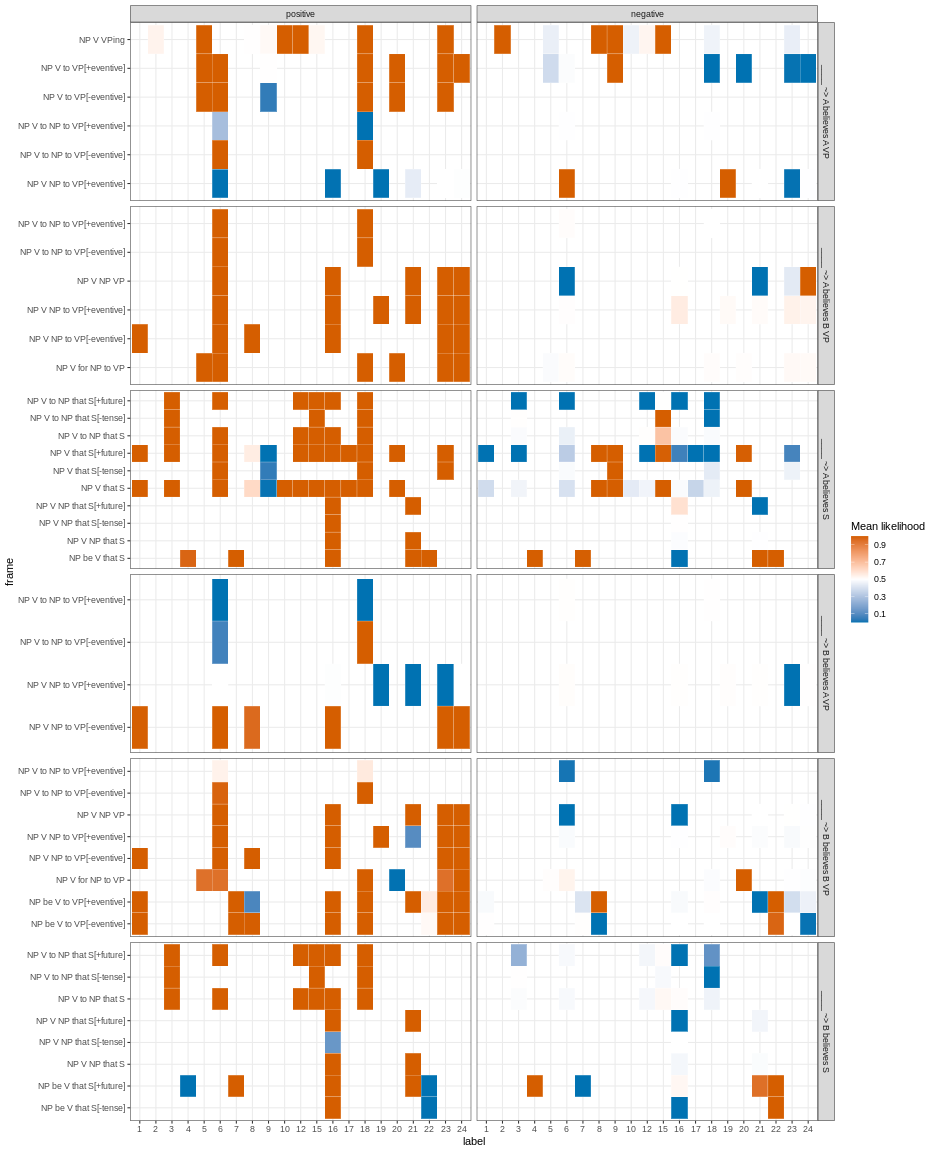

In [1833]:
%%R -i best_belief_desire_locs_w_melt -i cluster_order -w 13 -h 16 -u in

library(tidyverse)

theme_set(theme_bw())

best_belief_desire_locs_w_melt <- filter(best_belief_desire_locs_w_melt, inferencetype=='doxastic')

# cluster_order = c('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19')

best_belief_desire_locs_w_melt$label <- ordered(best_belief_desire_locs_w_melt$label,
                                                levels=cluster_order)

best_belief_desire_locs_w_melt$template <- factor(best_belief_desire_locs_w_melt$template)
best_belief_desire_locs_w_melt$polarity <- factor(best_belief_desire_locs_w_melt$polarity, levels=c("positive", "negative"))
# best_belief_desire_locs_w_melt$frame <- factor(best_belief_desire_locs_w_melt$frame)

g = ggplot(best_belief_desire_locs_w_melt, aes(y=frame, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5) +
# facet_wrap(best_belief_desire_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_belief_desire_locs_w_melt$template ~ best_belief_desire_locs_w_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free")
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing = unit(4, "lines"),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text=element_text(size=25, face="bold"),
      plot.margin=unit(c(0,0,0,2),"cm"))



ggsave('plots/doxastic-loadings-22.pdf', width=13, height=16, limitsize=FALSE)
ggsave('plots/doxastic-loadings-22.png', width=13, height=16, limitsize=FALSE)

g

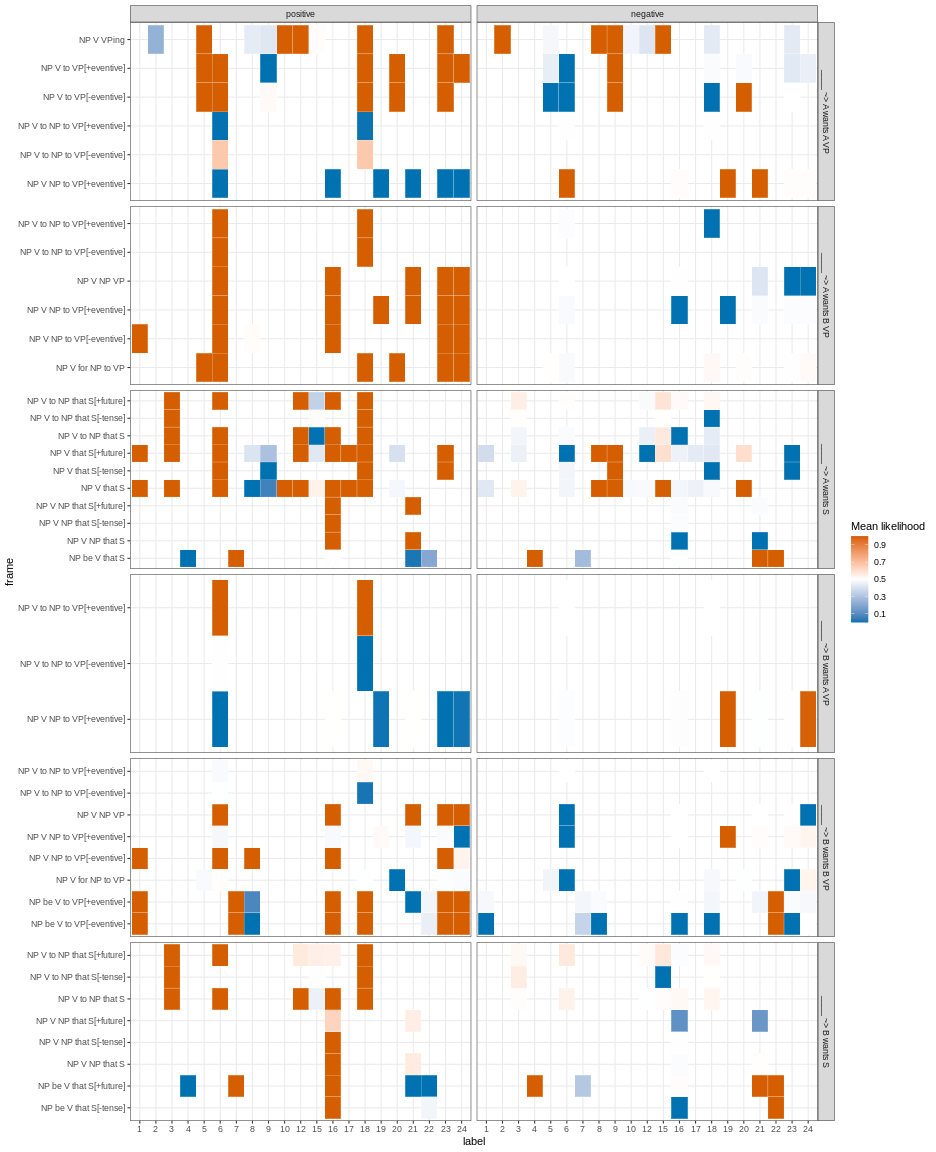

In [1834]:
%%R -i best_belief_desire_locs_w_melt -i cluster_order -w 13 -h 16 -u in

library(tidyverse)

theme_set(theme_bw())

best_belief_desire_locs_w_melt <- filter(best_belief_desire_locs_w_melt, inferencetype=='bouletic')

# cluster_order = c('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19')

best_belief_desire_locs_w_melt$label <- ordered(best_belief_desire_locs_w_melt$label,
                                                levels=cluster_order)

best_belief_desire_locs_w_melt$template <- factor(best_belief_desire_locs_w_melt$template)
best_belief_desire_locs_w_melt$polarity <- factor(best_belief_desire_locs_w_melt$polarity, levels=c("positive", "negative"))
# best_belief_desire_locs_w_melt$frame <- factor(best_belief_desire_locs_w_melt$frame)

g = ggplot(best_belief_desire_locs_w_melt, aes(y=frame, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5) +
# facet_wrap(best_belief_desire_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_belief_desire_locs_w_melt$template ~ best_belief_desire_locs_w_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free")
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing = unit(4, "lines"),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))



ggsave('plots/bouletic-loadings-22.pdf', width=13, height=16, limitsize=FALSE)
ggsave('plots/bouletic-loadings-22.png', width=13, height=16, limitsize=FALSE)

g

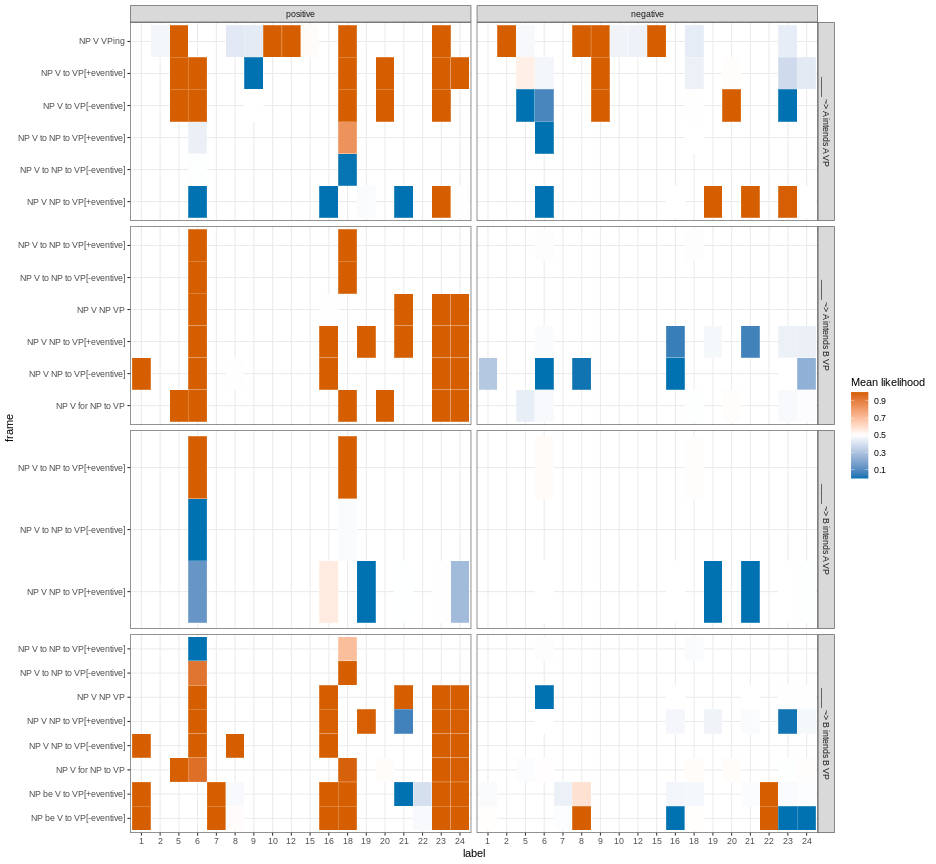

In [1835]:
%%R -i best_belief_desire_locs_w_melt -i cluster_order -w 13 -h 12 -u in

library(tidyverse)

theme_set(theme_bw())

best_belief_desire_locs_w_melt <- filter(best_belief_desire_locs_w_melt, inferencetype=='intention')

# cluster_order = c('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19')

best_belief_desire_locs_w_melt$label <- ordered(best_belief_desire_locs_w_melt$label,
                                                levels=cluster_order)

best_belief_desire_locs_w_melt$template <- factor(best_belief_desire_locs_w_melt$template)
best_belief_desire_locs_w_melt$polarity <- factor(best_belief_desire_locs_w_melt$polarity, levels=c("positive", "negative"))
# best_belief_desire_locs_w_melt$frame <- factor(best_belief_desire_locs_w_melt$frame)

g = ggplot(best_belief_desire_locs_w_melt, aes(y=frame, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5) +
# facet_wrap(best_belief_desire_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_belief_desire_locs_w_melt$template ~ best_belief_desire_locs_w_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free")
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing = unit(4, "lines"),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))



ggsave('plots/intention-loadings-22.pdf', width=13, height=16, limitsize=FALSE)
ggsave('plots/intention-loadings-22.png', width=13, height=16, limitsize=FALSE)

g

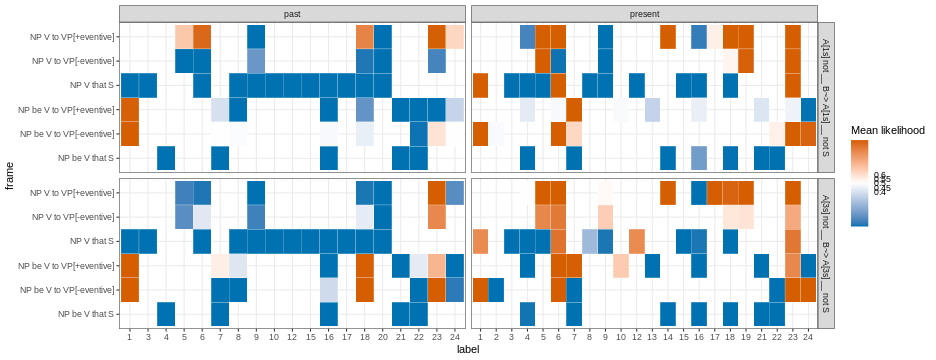

In [1836]:
%%R -i best_negraising_locs_w_melt -i cluster_order -w 13 -h 5 -u in

library(tidyverse)

theme_set(theme_bw())

best_negraising_locs_w_melt$label <- ordered(best_negraising_locs_w_melt$label,
                                           levels=cluster_order)

best_negraising_locs_w_melt$template <- factor(best_negraising_locs_w_melt$template)
best_veridicality_locs_w_melt$tense <- factor(best_veridicality_locs_w_melt$tense, levels=c("past", "present"))
# best_negraising_locs_w_melt$frame <- factor(best_negraising_locs_w_melt$frame)

g = ggplot(best_negraising_locs_w_melt, aes(y=frame, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.1, -0.05, 0, 0.05, 0.1),
                     labels=c(-0.1, -0.05, 0, 0.05, 0.1)+0.5) +
# facet_wrap(best_negraising_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_negraising_locs_w_melt$template ~ best_negraising_locs_w_melt$tense,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free")
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing = unit(4, "lines"),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/negraising-loadings-22.pdf', width=13, height=5, limitsize=FALSE)
ggsave('plots/negraising-loadings-22.png', width=13, height=5, limitsize=FALSE)

g

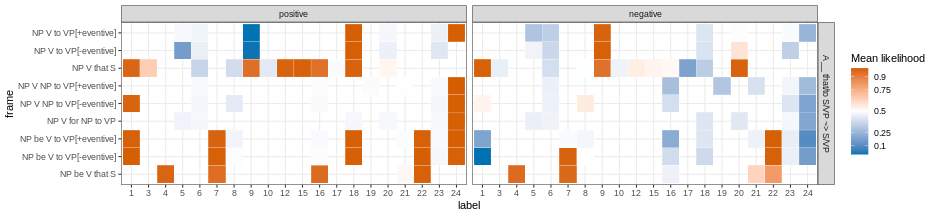

In [1837]:
%%R -i best_veridicality_locs_w_melt -i cluster_order -w 13 -h 3 -u in

library(tidyverse)

theme_set(theme_bw())

best_veridicality_locs_w_melt$label <- ordered(best_veridicality_locs_w_melt$label,
                                             levels=cluster_order)

best_veridicality_locs_w_melt$template <- factor(best_veridicality_locs_w_melt$template)
best_veridicality_locs_w_melt$polarity <- factor(best_veridicality_locs_w_melt$polarity, levels=c("positive", "negative"))
# best_veridicality_locs_w_melt$frame <- factor(best_veridicality_locs_w_melt$frame)

g = ggplot(best_veridicality_locs_w_melt, aes(y=frame, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5) +
# facet_wrap(best_veridicality_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_veridicality_locs_w_melt$template ~ best_veridicality_locs_w_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free")
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing = unit(4, "lines"),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/veridicality-loadings-22.png', width=13, height=12, limitsize=FALSE)
ggsave('plots/veridicality-loadings-22.pdf', width=13, height=12, limitsize=FALSE)

g

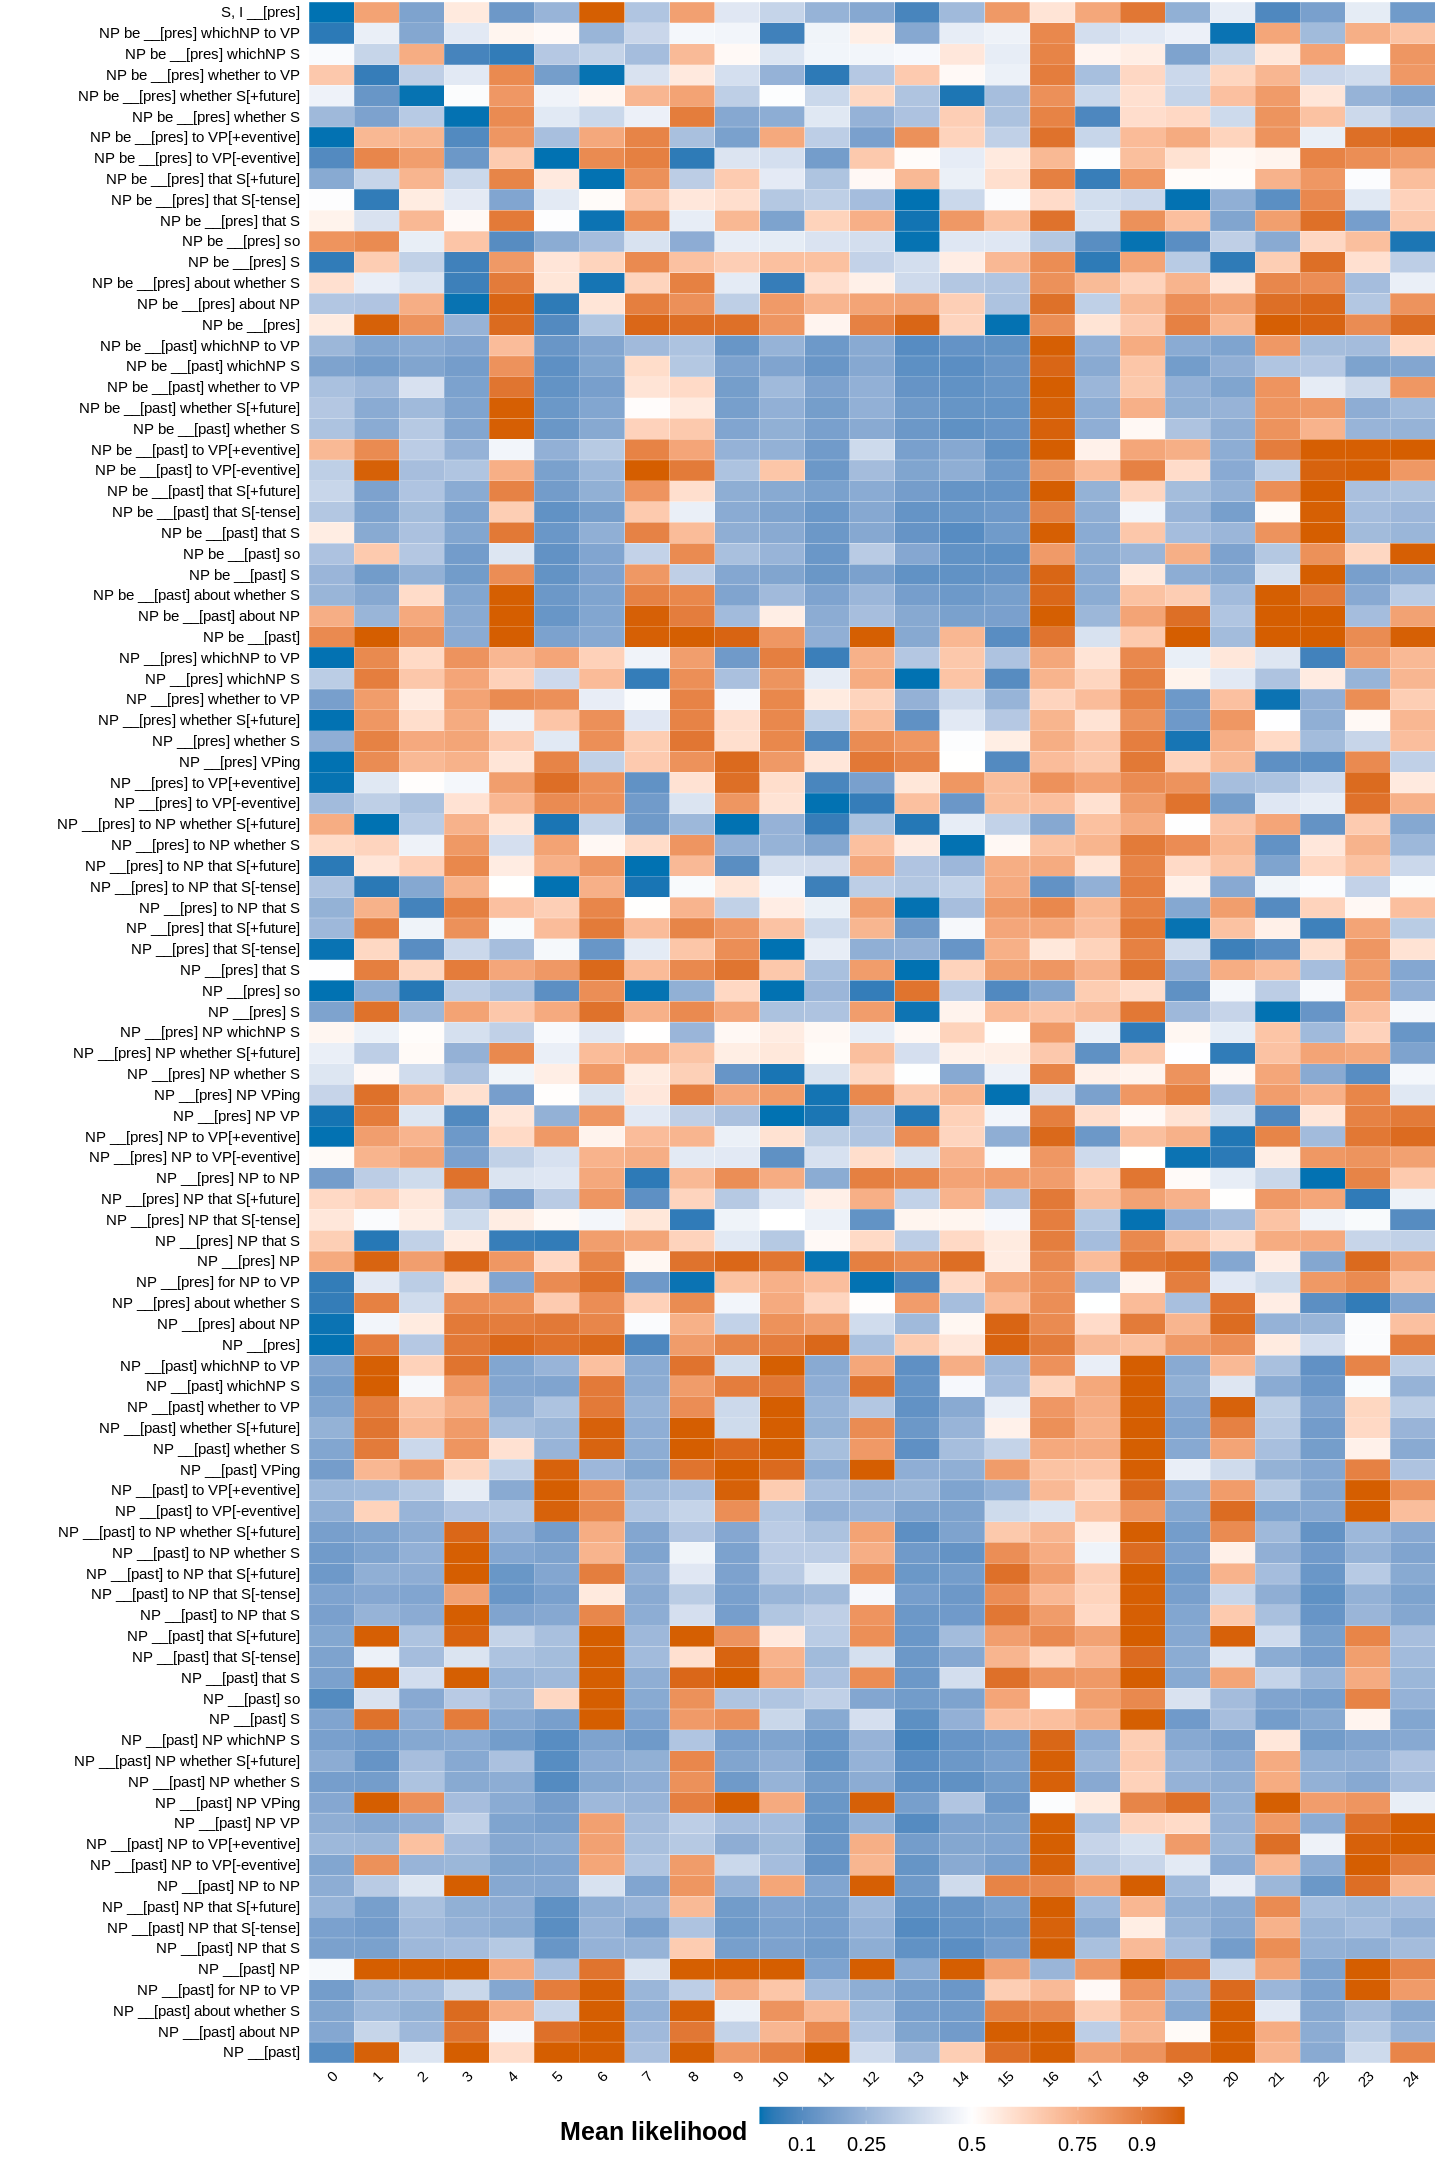

In [1838]:
%%R -i best_acceptability_locs_melt -i cluster_order -w 20 -h 30 -u in

library(tidyverse)

theme_set(theme_bw())

best_acceptability_locs_melt$label <- ordered(best_acceptability_locs_melt$label,
                                              levels=cluster_order)

g = ggplot(best_acceptability_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5) +
theme(axis.text=element_text(size=15, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/acceptability-loadings-22.png', width=20, height=30)
ggsave('plots/acceptability-loadings-22.pdf', width=20, height=30)

g

To determine a set of generalizations about these clusters, we apply principal component analysis (PCA) to the parameters of the property-specific probability distributions for each cluster.

In [1839]:
# all_locs_melt = pd.concat([best_veridicality_locs_melt,
#                            best_negraising_locs_melt,
#                            best_belief_desire_locs_melt])

# all_locs = all_locs_melt.pivot_table(index='label', columns='template', values='value')

# all_locs

In [1840]:
# pca_patterns = PCA().fit(all_locs.apply(lambda x: (x-x.mean())/x.std(), axis=0))

# pca_patterns_components = pd.DataFrame(pca_patterns.components_, columns=all_locs.columns)

# pca_patterns_components_melt = pd.melt(pca_patterns_components.T.reset_index(), id_vars="template")

# pca_patterns_components_melt

In [1841]:
# %%R -i pca_patterns_components_melt -w 20 -h 22 -u in

# belief_desire_template_order = append(belief_desire_template_order_f, belief_desire_template_order_nf)
# pca_patterns_components_melt$template = ordered(pca_patterns_components_melt$template,
#                                       levels=c(belief_desire_template_order,
#                                                negraising_template_order,
#                                               veridicality_template_order))

# g = ggplot(pca_patterns_components_melt, aes(y=template, x=as.factor(variable), fill=value)) +
# geom_tile(color="white") +
# scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
# theme(axis.text=element_text(size=25, color="black"),
#       axis.title=element_blank(),
#       axis.ticks=element_blank(),
#       legend.position="none",
#       panel.background=element_blank(),
#       panel.border=element_blank(),
#       panel.grid.major=element_blank(),
#       panel.grid.minor=element_blank(),
#       plot.background=element_blank(),
#      strip.background=element_rect(fill="white", color="white"),
#      strip.text=element_text(size=25, face="bold"),
#      plot.margin=unit(c(0,0,0,2),"cm"))

# ggsave('plots/pca-patterns-loadings-17.png', width=20, height=22)
# ggsave('plots/pca-patterns-loadings-17.pdf', width=20, height=22)

# g

In [1842]:
# all_locs_T = all_locs.apply(lambda x: (x-x.mean())/x.std(), axis=0).T
# all_locs_T = all_locs_T.reindex(cluster_order, axis=1)
# # all_locs_T.columns = all_locs_T.columns.astype(int)
# all_locs_T.columns.name = None

# pca_types = PCA().fit(all_locs_T)

# pca_types_components = pd.DataFrame(pca_types.components_, columns=all_locs_T.columns)

# pca_types_components_melt = pd.melt(pca_types_components.T.reset_index(), id_vars="index")

# pca_types_components_melt

In [1843]:
# %%R -i pca_types_components_melt -w 20 -h 14 -u in

# g = ggplot(pca_types_components_melt, aes(y=index, x=as.factor(variable), fill=value)) +
# geom_tile(color="white") +
# scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
# theme(axis.text=element_text(size=25, color="black"),
#       axis.title=element_blank(),
#       axis.ticks=element_blank(),
#       legend.position="none",
#       panel.background=element_blank(),
#       panel.border=element_blank(),
#       panel.grid.major=element_blank(),
#       panel.grid.minor=element_blank(),
#       plot.background=element_blank(),
#      strip.background=element_rect(fill="white", color="white"),
#      strip.text=element_text(size=25, face="bold"),
#      plot.margin=unit(c(0,0,0,2),"cm"))

# ggsave('plots/pca-types-loadings-17.png', width=20, height=14)
# ggsave('plots/pca-types-loadings-17.pdf', width=20, height=14)

# g

Finally, to visualize the relationship between each cluster and the syntax, we plot the coefficients of the best regression mapping clusters to syntax.

In [1844]:
# ma_cast_cats = pd.merge(ma_cast, best_model['component_probs_any'], 
#                         left_index=True, right_index=True)

# component_cols = list(range(best_n_components))

# X = ma_cast_cats[component_cols]
# Y = ma_cast_cats.drop(columns=component_cols)

# best_regression = RidgeCV(alphas=[0.001, 0.1, 0.2, 0.5, 1., 2., 5., 10.], cv=5).fit(X, Y)

In [1845]:
# best_regression_coefs = pd.DataFrame(best_regression.coef_, 
#                                      index=ma_cast.columns, 
#                                      columns=best_model['component_probs_any'].columns)

# best_regression_coefs_melt = pd.melt(best_regression_coefs.reset_index(), id_vars='frame')

# best_regression_coefs_melt['label'] = best_regression_coefs_melt.variable.map(cluster_labels)

# best_regression_coefs_melt

In [1846]:
# %%R -i best_regression_coefs -i best_regression_coefs_melt -i cluster_order -w 20 -h 25 -u in

# best_regression_coefs_melt$label = ordered(best_regression_coefs_melt$label,
#                                       levels=cluster_order)

# frame_order = row.names(best_regression_coefs)[rev(hclust(dist(best_regression_coefs))$order)]

# best_regression_coefs_melt$frame = ordered(best_regression_coefs_melt$frame,
#                                       levels=frame_order)

# g = ggplot(best_regression_coefs_melt, aes(y=frame, x=label, fill=value)) +
# geom_tile(color="white") +
# scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
# theme(axis.text=element_text(size=25, color="black"),
#       axis.title=element_blank(),
#       axis.ticks=element_blank(),
#       axis.text.x=element_text(angle=45, hjust=1),
#       legend.position="none",
#       panel.background=element_blank(),
#       panel.border=element_blank(),
#       panel.grid.major=element_blank(),
#       panel.grid.minor=element_blank(),
#       plot.background=element_blank(),
#      strip.background=element_rect(fill="white", color="white"),
#      strip.text=element_text(size=25, face="bold"),
#      plot.margin=unit(c(0,0,0,2),"cm"))

# ggsave('plots/regression-coefs-15.png', width=20, height=25)
# ggsave('plots/regression-coefs-15.pdf', width=20, height=25)

# g

In our analysis, we focus on the relationship between underlying semantic components and syntactic features. To do this, we treat syntactic frames as individual observations, with a vector of syntactic features (e.g., "NP_subj", "whether to VP", etc.) for each observation (note that a particular frame may appear in multiple obligations, as some frames are associated with multiple possible parses).

Then, given the matrix of cluster (inference pattern) weights by frame, we "rotate" the matrix by the component x cluster matrix from the PCA to obtain a matrix relating the underlying semantic components to frames.

We try to learn a mapping from components to features (i.e., a matrix of component x feature weights) that predicts the syntactic features from the component weights for each observation.

In [1847]:
# from collections import OrderedDict

# frame_to_constituents = OrderedDict({
#     'NP was Ved whichNP to VP': {
#         ("NP_subj", "NP_obj", "whichNP to VP"),
#         ("NP_obj", "whichNP to VP")
#     },
#     'NP Ved for NP to VP': {
#         ("NP_subj", "for NP to VP"),
#         ("NP_subj", "PP_for", "to VP")
#     },
#     'NP Ved NP to VP[+eventive]': {
#         ("NP_subj", "NP to VP[+eventive]"),
#         ("NP_subj", "NP_obj", "to VP[+eventive]")
#     },
#     'NP was Ved whether to VP': {
#         ("NP_subj", "NP_obj", "whether to VP"),
#         ("NP_obj", "whether to VP")
#     },
#     'NP Ved to VP[+eventive]': {
#         ("NP_subj", "to VP[+eventive]")
#     },
#     'NP Ved NP to NP': {
#         ("NP_subj", "NP_obj", "NP_iobj")
#     },
#     'NP Ved NP that S': {
#         ("NP_subj", "NP_obj", "that S")
#     },
#     'NP was Ved about NP': {
#         ("NP_subj", "NP_obj", "about NP") ,
#         ("NP_obj", "about NP")
#     },
#     'NP was Ved that S[-tense]': {
#         ("NP_subj", "NP_obj", "S[-tense]") ,
#         ("NP_obj", "S[-tense]")
#     },
#     'NP Ved to NP that S[+future]': {
#         ("NP_subj", "NP_iobj", "that S[+future]")
#     },
#     'NP Ved whether to VP': {
#         ("NP_subj", "whether to VP")
#     },
#     'NP Ved whichNP to VP': {
#         ("NP_subj", "whichNP to VP")
#     },
#     'NP Ved about whether S': {
#         ("NP_subj", "about whether S")
#     },
#     'NP Ved whichNP S': {
#         ("NP_subj", "whichNP S")
#     },
#     'NP Ved that S[-tense]': {
#         ("NP_subj", "that S[-tense]")
#     },
#     'NP Ved whether S[+future]': {
#         ("NP_subj", "whether S[+future]")
#     },
#     'NP was Ved that S[+future]': {
#         ("NP_subj", "NP_obj", "that S[+future]") ,
#         ("NP_obj", "that S[+future]")
#     },
#     'NP Ved to NP whether S': {
#         ("NP_subj", "NP_iobj", "whether S")
#     },
#     'NP Ved': {
#         ("NP_subj",)
#     },
#     'NP Ved NP to VP[-eventive]': {
#         ("NP_subj", "NP to VP[-eventive]"),
#         ("NP_subj", "NP_obj", "to VP[-eventive]"),
#         ("NP_subj", "NP to VP[-eventive]")
#     },
#     'NP was Ved so': {
#         ("NP_obj", "so"),
#         ("NP_subj", "NP_obj", "so")
#     },
#     'NP Ved so': {
#         ("NP_subj", "so")
#     },
#     'NP Ved NP that S[+future]': {
#         ("NP_subj", "NP_obj", "that S[+future]")
#     },
#     'NP Ved NP whether S[+future]': {
#         ("NP_subj", "NP_obj", "whether S[+future]")
#     },
#     'NP Ved to NP whether S[+future]': {
#         ("NP_subj", "NP_iobj", "whether S[+future]")
#     },
#     'NP was Ved that S': {
#         ("NP_obj", "that S"),
#         ("NP_subj", "NP_obj", "that S")
#     },
#     'NP Ved NP whether S': {
#         ("NP_subj", "NP_obj", "whether S")
#     },
#     'NP was Ved whether S': {
#         ("NP_obj", "whether S"),
#         ("NP_subj", "NP_obj", "whether S")
#     },
#     'NP was Ved to VP[-eventive]': {
#         ("NP_obj", "to VP[-eventive]"),
#         ("NP_subj", "NP_obj", "to VP[-eventive]"),
#         ("NP_subj", "NP to VP[-eventive]")
#     },
#     'NP Ved NP VP': {
#         ("NP_subj", "NP_obj", "VP"),
#         ("NP_subj", "NP VP")
#     },
#     'NP Ved VPing': {
#         ("NP_subj", "VPing")
#     },
#     'NP was Ved to VP[+eventive]': {
#         ("NP_obj", "to VP[+eventive]"),
#         ("NP_subj", "NP_obj", "to VP[+eventive]"),
#         ("NP_subj", "NP to VP[+eventive]")
#     },
#     'NP Ved NP that S[-tense]': {
#         ("NP_subj", "NP_obj", "that S[-tense]")
#     },
#     'NP Ved that S': {
#         ("NP_subj", "that S")
#     },
#     'NP was Ved': {
#         ("NP_obj",),
#         ("NP_subj", "NP_obj")
#     },
#     'NP Ved S': {
#         ("NP_subj", "S")
#     },
#     'NP Ved that S[+future]': {
#         ("NP_subj", "that S[+future]")
#     },
#     'NP was Ved about whether S': {
#         ("NP_subj", "NP_obj", "about whether S") ,
#         ("NP_obj", "about whether S")
#     },
#     'NP Ved NP': {
#         ("NP_subj", "NP_obj")
#     },
#     'NP Ved NP VPing': {
#         ("NP_subj", "NP_obj", "VPing"),
#         ("NP_subj", "NP VPing")
#     },
#     'NP Ved NP whichNP S': {
#         ("NP_subj", "NP_obj", "whichNP S")
#     },
#     'NP Ved about NP': {
#         ("NP_subj", "about NP")
#     },
#     'NP was Ved S': {
#         ("NP_subj", "NP_obj", "S") ,
#         ("NP_obj", "S")
#     },
#     'NP Ved to NP that S': {
#         ("NP_subj", "NP_iobj", "that S"),
#     },
#     'NP was Ved whether S[+future]': {
#         ("NP_subj", "NP_obj", "whether S[+future]") ,
#         ("NP_obj", "whether S[+future]")
#     },
#     'NP Ved whether S': {
#         ("NP_subj", "whether S")
#     },
#     'NP was Ved whichNP S': {
#         ("NP_subj", "NP_obj", "whichNP S") ,
#         ("NP_obj", "whichNP S")
#     },
#     'NP Ved to NP that S[-tense]': {
#         ("NP_subj", "NP_iobj", "that S[-tense]")
#     },
#     'NP Ved to VP[-eventive]': {
#         ("NP_subj", "to VP[-eventive]")
#     }
#     # S, I V?
# })

# SYNTACTIC_FEATURES = []
# for frame, constituents in frame_to_constituents.items():
#     for parse in constituents:
#         for x in parse:
#             if x not in SYNTACTIC_FEATURES:
#                 SYNTACTIC_FEATURES.append(x)
                
# SYNTACTIC_FEATURES

In [1848]:
# best_regression_coefs_reordered = best_regression_coefs.rename(columns=cluster_labels).reindex(cluster_order, axis=1)

# print(all_locs_T.columns)
# print(best_regression_coefs_reordered.columns)

# frame_component_weights = pd.DataFrame(pca_types.transform(best_regression_coefs_reordered),
#                                        index=best_regression_coefs_reordered.index)

# # best_regression_coefs_reordered.head()
# frame_component_weights.head()

In [1849]:
# frame_component_weights_melt = pd.melt(frame_component_weights.reset_index(), id_vars='frame')

# frame_component_weights_melt['label'] = frame_component_weights_melt.variable.map(lambda x: str(x))
# frame_component_weights_order = [str(i) for i in range(best_n_components)]

# frame_component_weights_melt

In [1850]:
# %%R -i frame_component_weights -i frame_component_weights_melt -i frame_component_weights_order -w 20 -h 25 -u in

# frame_component_weights_melt$label = ordered(frame_component_weights_melt$label,
#                                               levels=frame_component_weights_order)

# frame_order = row.names(frame_component_weights)[rev(hclust(dist(frame_component_weights))$order)]

# frame_component_weights_melt$frame = ordered(frame_component_weights_melt$frame,
#                                       levels=frame_order)

# g = ggplot(frame_component_weights_melt, aes(y=frame, x=label, fill=value)) +
# geom_tile(color="white") +
# scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
# theme(axis.text=element_text(size=25, color="black"),
#       axis.title=element_blank(),
#       axis.ticks=element_blank(),
#       axis.text.x=element_text(angle=45, hjust=1),
#       legend.position="none",
#       panel.background=element_blank(),
#       panel.border=element_blank(),
#       panel.grid.major=element_blank(),
#       panel.grid.minor=element_blank(),
#       plot.background=element_blank(),
#      strip.background=element_rect(fill="white", color="white"),
#      strip.text=element_text(size=25, face="bold"),
#      plot.margin=unit(c(0,0,0,2),"cm"))

# ggsave('plots/frame-component-weights-17.png', width=20, height=25)
# ggsave('plots/frame-component-weights-17.pdf', width=20, height=25)

# g

In [1851]:
# frame_component_weights = frame_component_weights.reset_index()
# frame_component_weights = frame_component_weights.rename(columns = {'index':'frame'})
# frame_component_weights = frame_component_weights[frame_component_weights['frame'].isin(frame_to_constituents.keys())]

# frame_component_weights.head()

In [1852]:
# component_syntax_data = []
# for frame, constituents in frame_to_constituents.items():
#     for parse in constituents:
#         component_syntax_data.append({'frame':frame,
#                                       'component_weights':np.array(frame_component_weights.query(f"frame=='{frame}'").iloc[0][1:].astype(float)),
#                                       'syntactic_features':np.array([1 if x in parse else 0 for x in SYNTACTIC_FEATURES])
#                                      })
        
# component_syntax_data[0:3]

In [1853]:
# class SyntacticFeaturePredictor():
#     def __init__(self, data):
#         self.data = data
#         self.n_obs = len(data)
#         self._prepare_data()
        
#         self.mapping = nn.Linear(self.n_components, self.n_features, bias=False).double()
        
#     def _prepare_data(self):
#         self.X = torch.tensor([x['component_weights'] for x in self.data])
#         self.Y = torch.tensor([x['syntactic_features'] for x in self.data]).double()
#         self.n_components = self.X.shape[-1]
#         self.n_features = self.Y.shape[-1]
        
#     def fit(self, n_epoch=1000, lr=1e-1, verbosity=100):
#         criterion = nn.BCEWithLogitsLoss()
#         optimizer = optim.SGD(self.mapping.parameters(), lr=lr)
#         for epoch in range(n_epoch):
#             optimizer.zero_grad()
#             features = self.mapping(self.X)
#             loss = criterion(features, self.Y)
#             loss.backward()
#             optimizer.step()
#             if epoch % verbosity == 0:
#                 print('Loss: {:.3f}'.format(loss.item()))
                
#     def pred(self):
#         features = self.mapping(self.X)
#         return (features>0.5).double()
        
#     def weights(self):
#         with torch.no_grad():
#             return self.mapping.weight.detach().data.numpy()
    

# syntactic_feature_pred = SyntacticFeaturePredictor(component_syntax_data)
# syntactic_feature_pred.fit()
# syntactic_feature_pred.pred()
# # syntactic_feature_pred.Y